<a href="https://colab.research.google.com/github/eriksali/DNN_2023_NLP/blob/main/pass_review_yellow_mountain_not_Multicore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir review_trip

In [ ]:
!zip -r reviews_words.zip reviews_words/

In [ ]:

imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair
    
     
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"  
## !unzip -uq "/content/reviews_words.zip" -d "/content/"   
!unzip -uq "/content/review_huangshan.zip" -d "/content/"   

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
## dirpath = '/content/reviews_words/'
dirpath = '/content/review_huangshan/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):
    
    doc = re.sub("([^\x00-\x7F])+"," ", str(doc))
    ## doc = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(doc))
    ## print(doc)
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    for z in stop_free:
      
      ## string = 'abcd1234efg567'
      z = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(z))
      
      newstring = ''.join([i for i in z if not i.isdigit()]).lower()
      if not(len(newstring) < 2):
          ## print(newstring)
          stringVal = stringVal + " " + newstring
   
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)  
   
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split() if not word.isdigit())  
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus_text]
## data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
##id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(clean_corpus)

# Create Corpus
texts = clean_corpus

##

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]



In [ ]:
'''
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
'''

In [ ]:

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    ## nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(texts)  # processed Text Data!

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                          corpus=corpus, 
                                          num_topics=4, 
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word, 
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500) 
                                          ##iterations=1500)  
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


pprint(lda_model.print_topics())

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, topn=20)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Name']
df_dominant_topic.head(20)

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", 'Text', 'Name']

# Show
sent_topics_sorteddf_mallet.head(20)

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.2262   
1         1.0              0.3198   
2         2.0              0.4920   
3         3.0              0.5313   
4         4.0              0.5182   
5         5.0              0.5683   
6         6.0              0.4918   
7         7.0              0.3115   
8         8.0              0.4713   
9         9.0              0.8812   
10       10.0              0.2770   
11       11.0              0.4352   
12       12.0              0.3034   
13       13.0              0.4050   
14       14.0              0.8410   
15       15.0              0.9532   
16       16.0              0.5302   
17       17.0              0.3559   
18       18.0              0.4294   
19       19.0              0.3672   

                                                                                               Keywords  \
0   shape, vary, paper, awesome, surprising, relative, peculiarly, low, especially, spring, ton, ski...   
1   monkey, young, actually, section, real, breathtaking, disappoint, experienced, everywhere, body,...   
2   stone, building, concrete, well_maintaine, explore, charge, impressive, granite, budget, stuff, ...   
3   season, stop, eat, leader, camera, manage, speak, pavilion, available, quickly, pine, wish, pair...   
4   tour, guide, difficult, town, rock, tip, attraction, private, huangshan, accommodation, service,...   
5   find, use, full, enjoy, site, really, look, close, time, alone, tree, new, snow, many, popular, ...   
6   buy, tourist, food, water, group, entrance, also, warm, small, go, much, walk, bring, stop, sell...   
7   english, evening, luggage, move, problem, item, outdoor, aim, numerous, like, taxi, country, tra...   
8   free, shuttle, pool, hot_spre, male, bottle, expectation, water, toilet, include, provide, massa...   
9   old, street, local, shop, tea, chinese, visit, good, find, many, food, place, worth, offer, grea...   
10  park, sign, loop, keep, north, together, run, entire, require, animal, online, backtrack, grand_...   
11  course, lovely, level, large, seem, atmosphere, crowded, happy, peace, ancient_street, confuse, ...   
12  location, clean, various, put, facility, challenge, pick, ever, number, company, volume, mega, r...   
13  photo, miss, famous, room, away, walking_stick, prepared, seem, shade, crowded, forget, man, bar...   
14  mountain, visit, day, trail, see, view, crowd, path, experience, worth, weather, hiking, beautif...   
15  mountain, take, car, cable, go, walk, hotel, day, get, see, view, top, time, hour, step, way, pe...   
16  different, map, place, definitely, weekend, worth, leg, know, wonderful, possible, pave, trash, ...   
17  western, line, eastern, ticket, hr, crowd, yell, case, love, loud, turn, fit, enough, picture, r...   
18  bus, pm, rmb, city, main, cost, follow, litter, porter, last, celestial, start, booking, limited...   
19  nice, thing, fantastic, watch, surround, call, dinner, incredible, staircase, noise, ankle, rubb...   

                                                                                                   Text  \
0   [hairy, tofu, big, great, opportunity, see, typical, tiere, gabled, region, interesting, especia...   
1   [bind, talk, leisure, traveler, want, confine, package, huangshan, tour, want, determine, itiner...   
2   [interesting, ware, offer, include, beautiful, stone, wooden, metal, sculpture, building, also, ...   
3   [weather, tricky, lot, obscure, view, luck, view, breath_take, mountain, distance, appear, deep,...   
4   [family, adult, part, week, tour, visit, great, tour, guide, visit, mountain, breathtaking, day,...   
5   [tell, govevrnment, spend, year, maintain, tree, branch, trunk, mechanically, support, nice, vie...   
6                 [get, fuss, place, expensive, justify, interesting, save, money, jiulong, much, well]   
7    [surprised, peaceful, clean, atmosphere, friendly, shop, owner, nice, outdoor, spot, lunch, drink]   
8   [get, hot_s

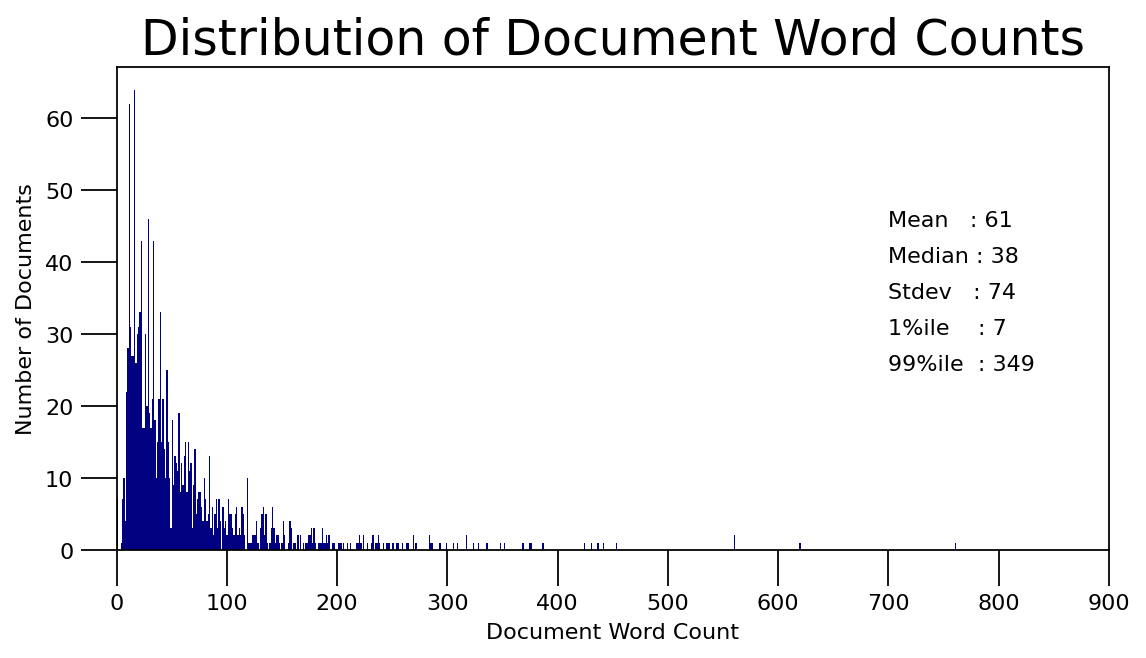

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,4), dpi=160)
plt.hist(doc_lens, bins = 900, color='navy')
plt.text(700, 45, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(700, 40, "Median : " + str(round(np.median(doc_lens))))
plt.text(700, 35, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(700, 30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(700, 25, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
<ipython-input-137-4edc0a444394>:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


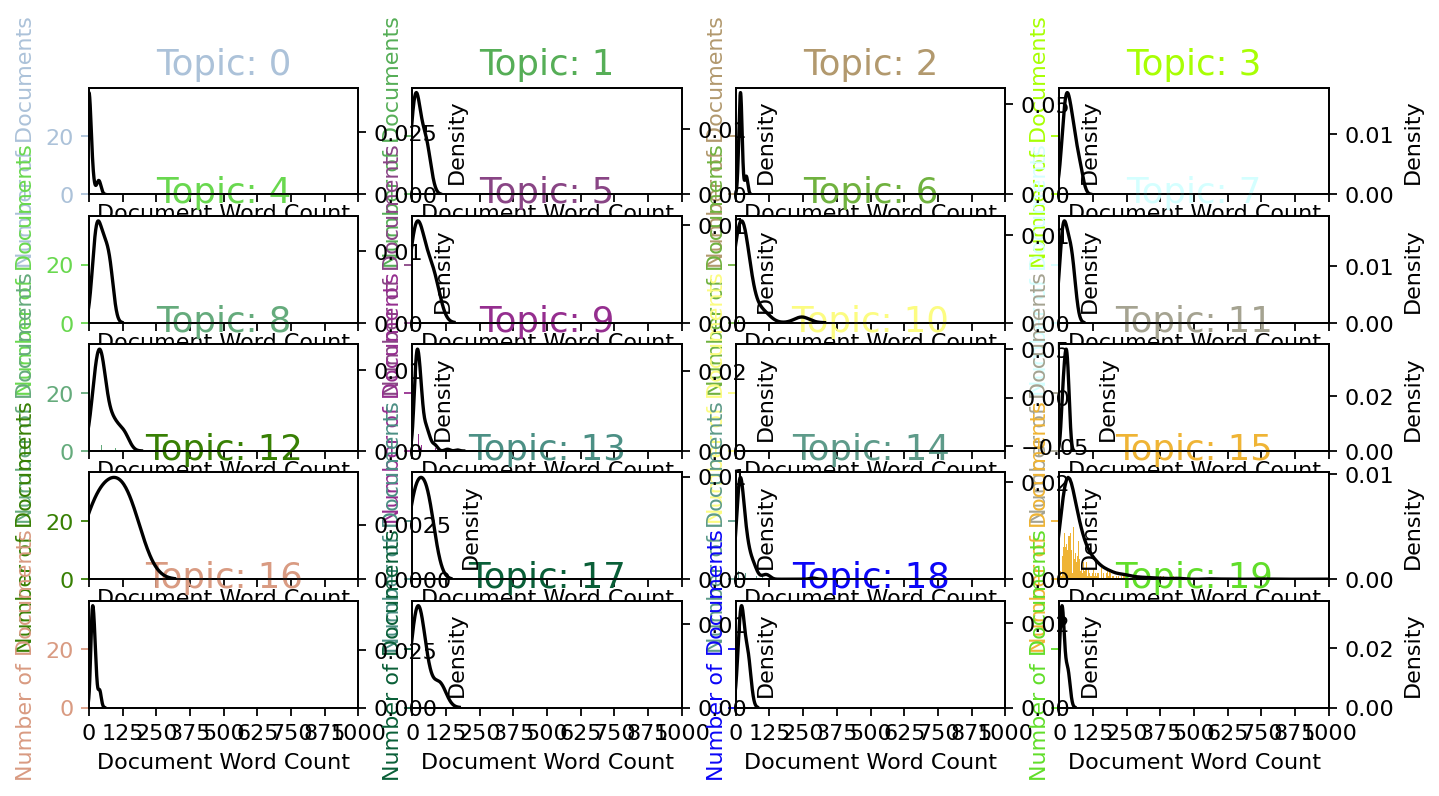

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
##cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,4,figsize=(10,5), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
## fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

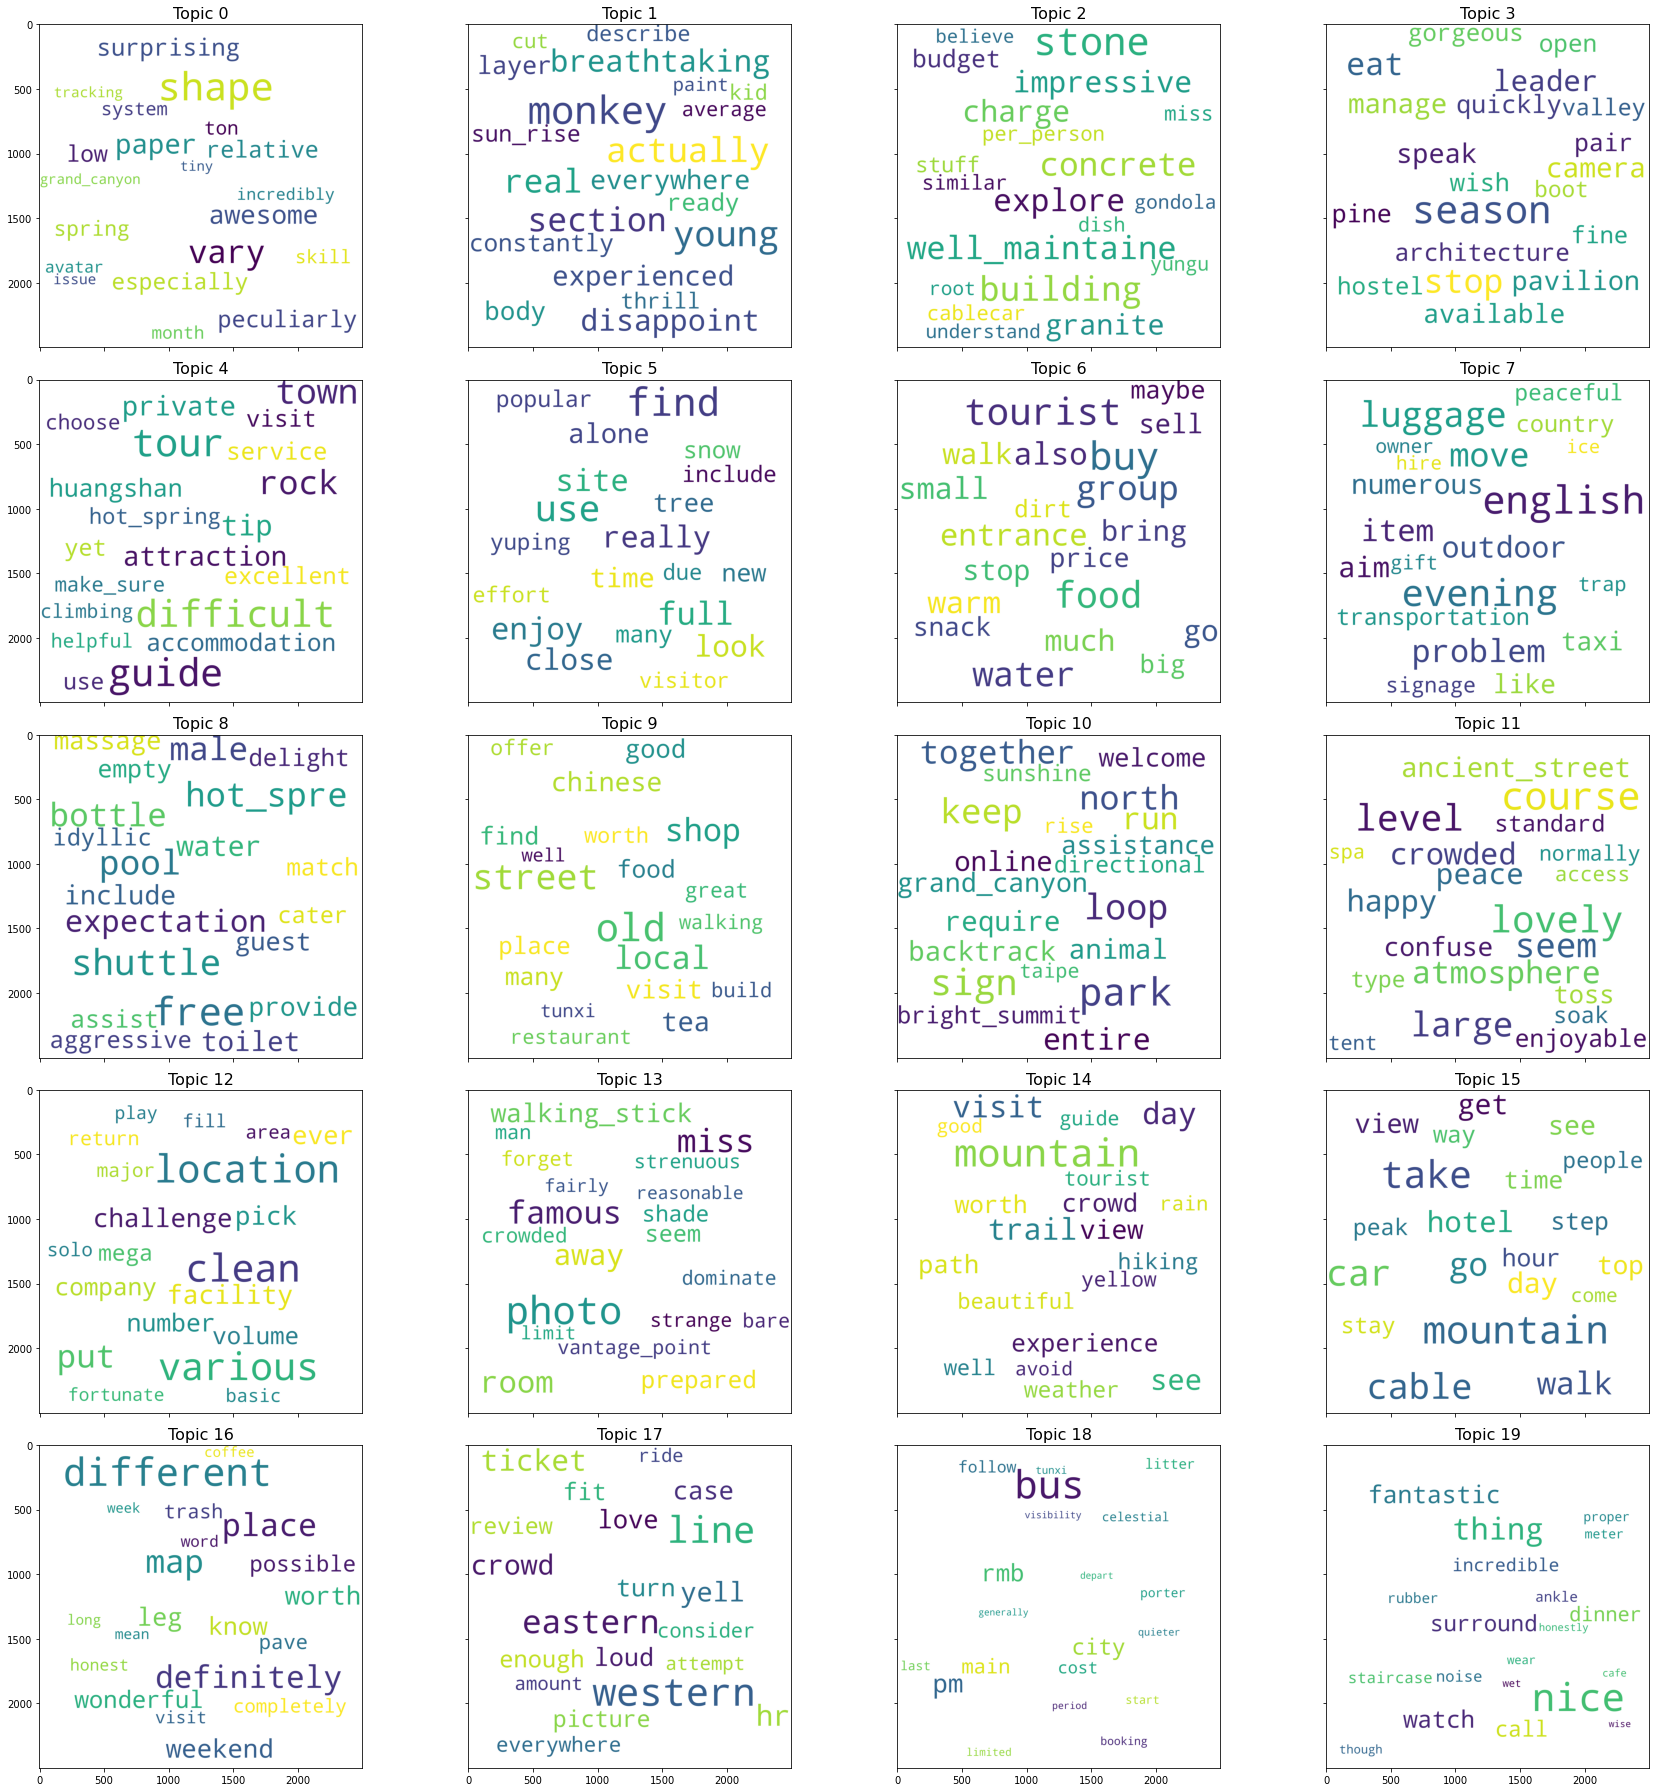

"\nplt.figure(0)\nfor i in range(5):\n    for j in range(4):\n        ax = plt.subplot2grid((5,4), (i,j))\nplt.show()\n\n\nimport matplotlib.pyplot as plt\nimport matplotlib.gridspec as gridspec\nimport numpy as np\n\ntry:\n    from itertools import product\nexcept ImportError:\n    # product is new in v 2.6\n    def product(*args, **kwds):\n        pools = map(tuple, args) * kwds.get('repeat', 1)\n        result = [[]]\n        for pool in pools:\n            result = [x+[y] for x in result for y in pool]\n        for prod in result:\n            yield tuple(prod)\n\n\ndef squiggle_xy(a, b, c, d, i=np.arange(0.0, 2*np.pi, 0.05)):\n    return np.sin(i*a)*np.cos(i*b), np.sin(i*c)*np.cos(i*d)\n\nfig = plt.figure(figsize=(8, 8))\n\n# gridspec inside gridspec\nouter_grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.0)\n\nfor i in range(16):\n    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 3,\n            subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)\n    a, b = int(i/4)+1,i%4+

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

##cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS

'''
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w',
           edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud", fontsize=20)
plt.show()
'''

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=20,
                  ##colormap='tab10',
                  ##color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,  num_topics=20, num_words=20)

fig, axes = plt.subplots(5, 4, figsize=(25,25), sharex=True, sharey=True)

##for i, ax in enumerate(axes):
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    #print(i)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ##plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w',edgecolor='k')
    #fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w',edgecolor='k')
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('on')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('on')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


'''
plt.figure(0)
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
plt.show()


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

try:
    from itertools import product
except ImportError:
    # product is new in v 2.6
    def product(*args, **kwds):
        pools = map(tuple, args) * kwds.get('repeat', 1)
        result = [[]]
        for pool in pools:
            result = [x+[y] for x in result for y in pool]
        for prod in result:
            yield tuple(prod)


def squiggle_xy(a, b, c, d, i=np.arange(0.0, 2*np.pi, 0.05)):
    return np.sin(i*a)*np.cos(i*b), np.sin(i*c)*np.cos(i*d)

fig = plt.figure(figsize=(8, 8))

# gridspec inside gridspec
outer_grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.0)

for i in range(16):
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 3,
            subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
    a, b = int(i/4)+1,i%4+1
    for j, (c, d) in enumerate(product(range(1, 4), repeat=2)):
        ax = plt.Subplot(fig, inner_grid[j])
        ax.plot(*squiggle_xy(a, b, c, d))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

all_axes = fig.get_axes()

#show only the outside spines
for ax in all_axes:
    for sp in ax.spines.values():
        sp.set_visible(False)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.show()
'''

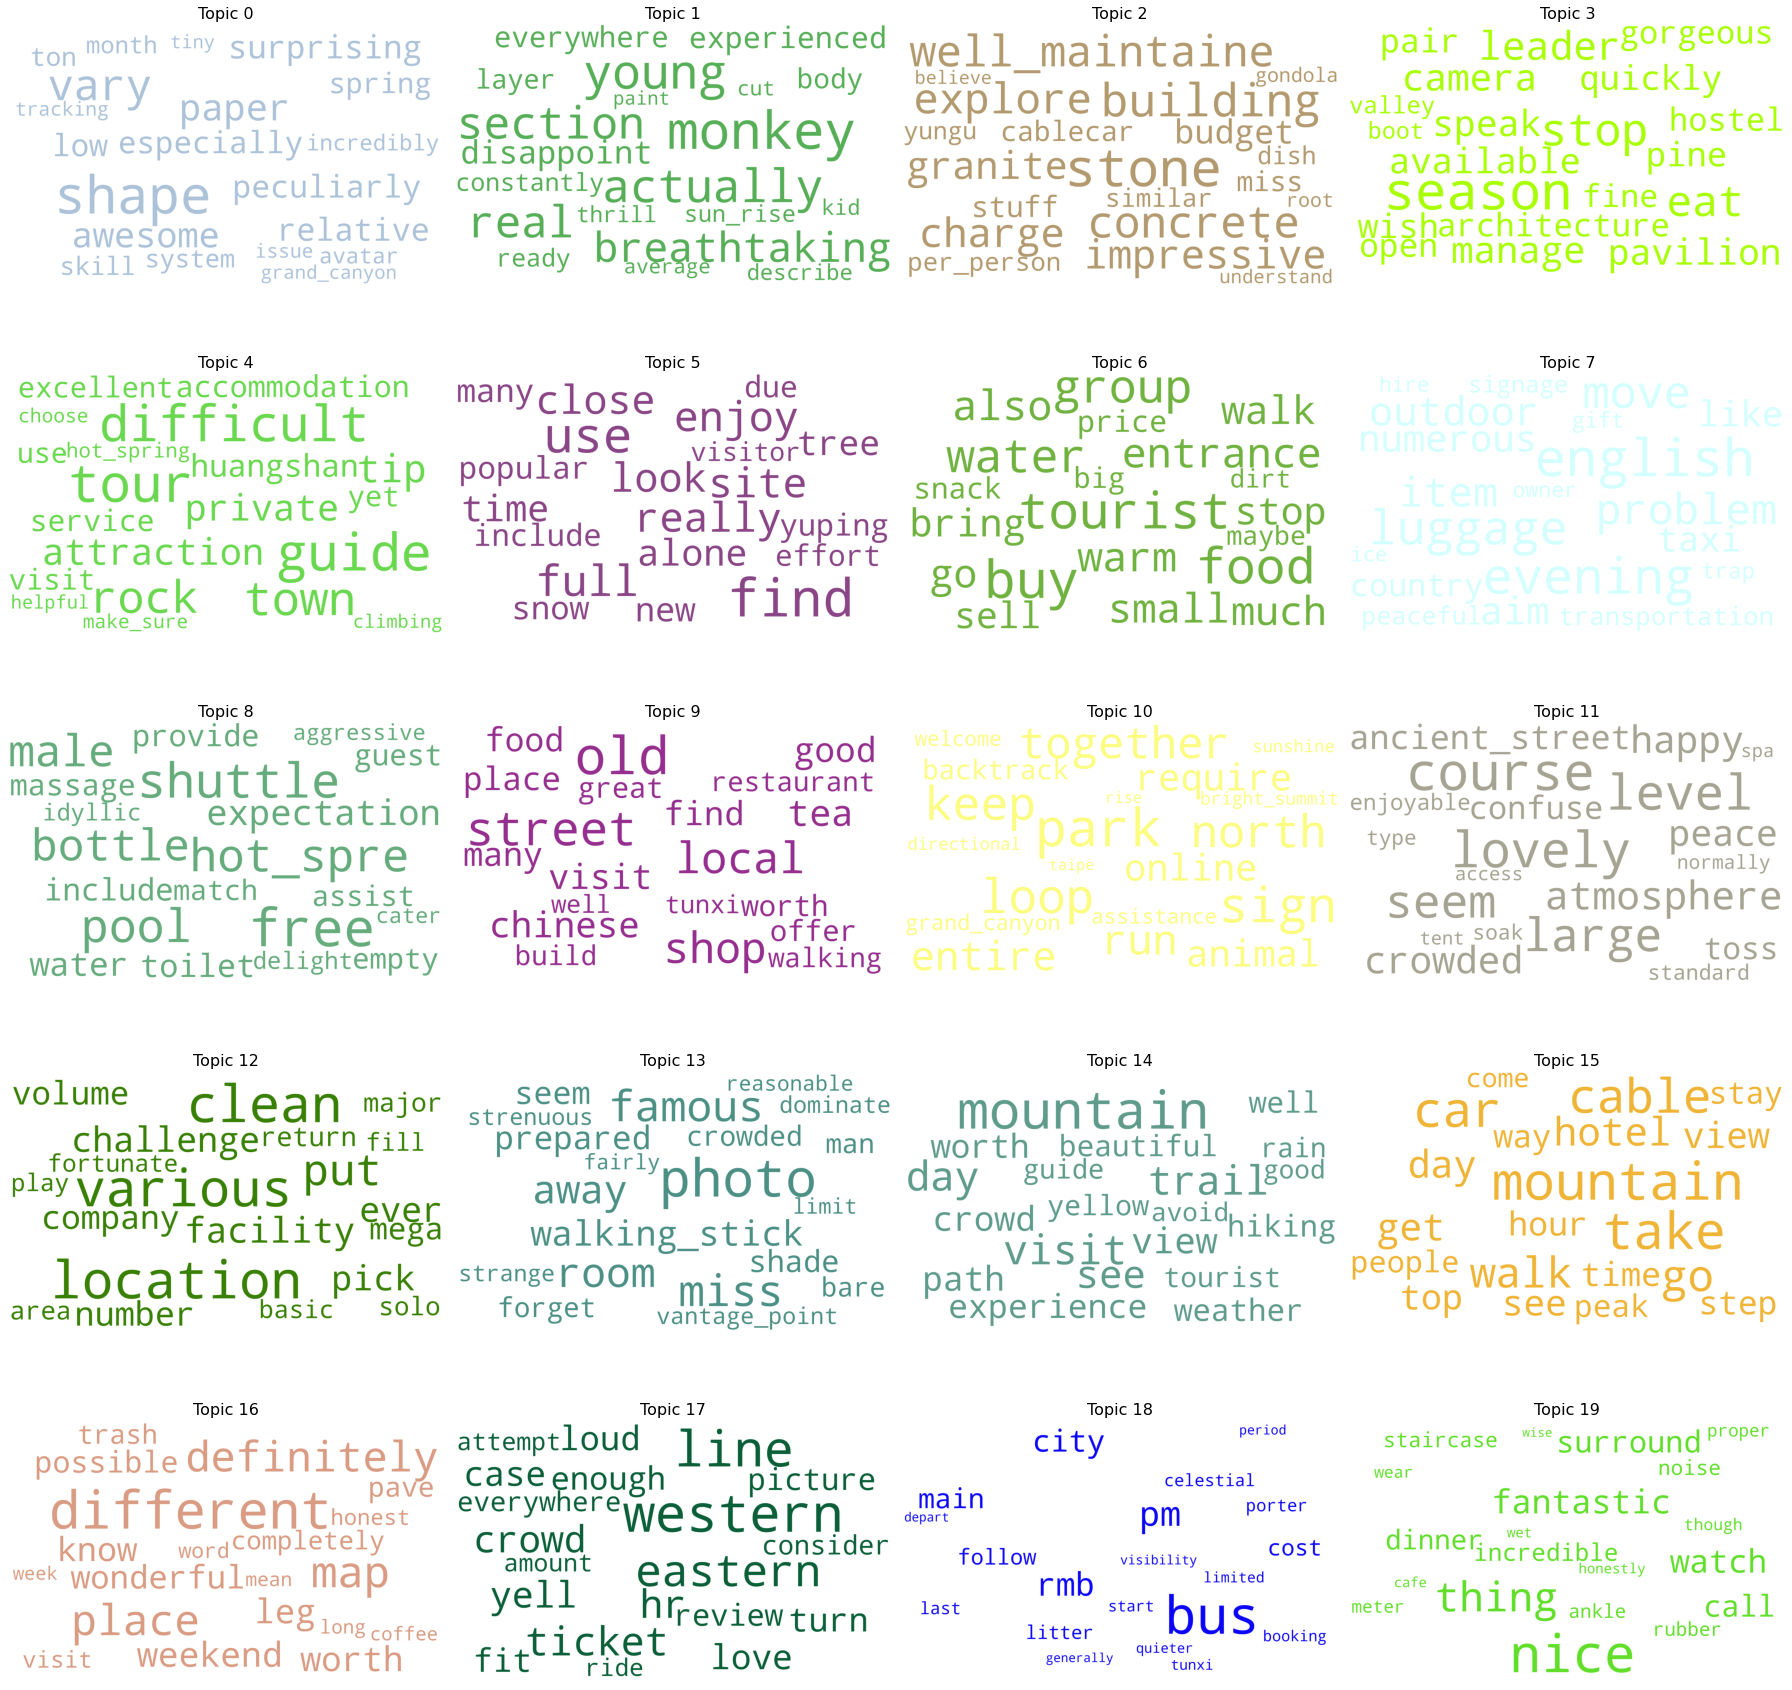

'\ndef create_wordcloud(model, topic):\n    text = {word: value for word, value in model.show_topic(topic)}\n    wc = WordCloud(background_color="white", max_words=1000)\n    wc.generate_from_frequencies(text)\n    plt.imshow(wc, interpolation="bilinear")\n    plt.axis("off")\n    plt.title("Topic" + " "+ str(topic))\n    plt.show()\n\nfor i in range(1, 15):\n    create_wordcloud(lda_model, topic=i)\n'

In [ ]:

'''
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
import gensim
import matplotlib.pyplot as plt
from wordcloud import WordCloud

common_dictionary = Dictionary(common_texts) # create corpus
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

lda_model = gensim.models.LdaModel(common_corpus, num_topics=20) # train model on corpus
for t in range(lda_model.num_topics):
    plt.figure()
    ##plt.imshow(WordCloud().fit_words(lda_model.show_topic(t, 200)))
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()
    

'''
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

##cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1500,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

##topics = lda_model.show_topics(formatted=False)
topics = lda_model.show_topics(formatted=False,  num_topics=20, num_words=20)

##fig, axes = plt.subplots(2, 3, figsize=(12,10), sharex=True, sharey=True)
fig, axes = plt.subplots(5, 4, figsize=(25,25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

'''
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

for i in range(1, 15):
    create_wordcloud(lda_model, topic=i)
'''

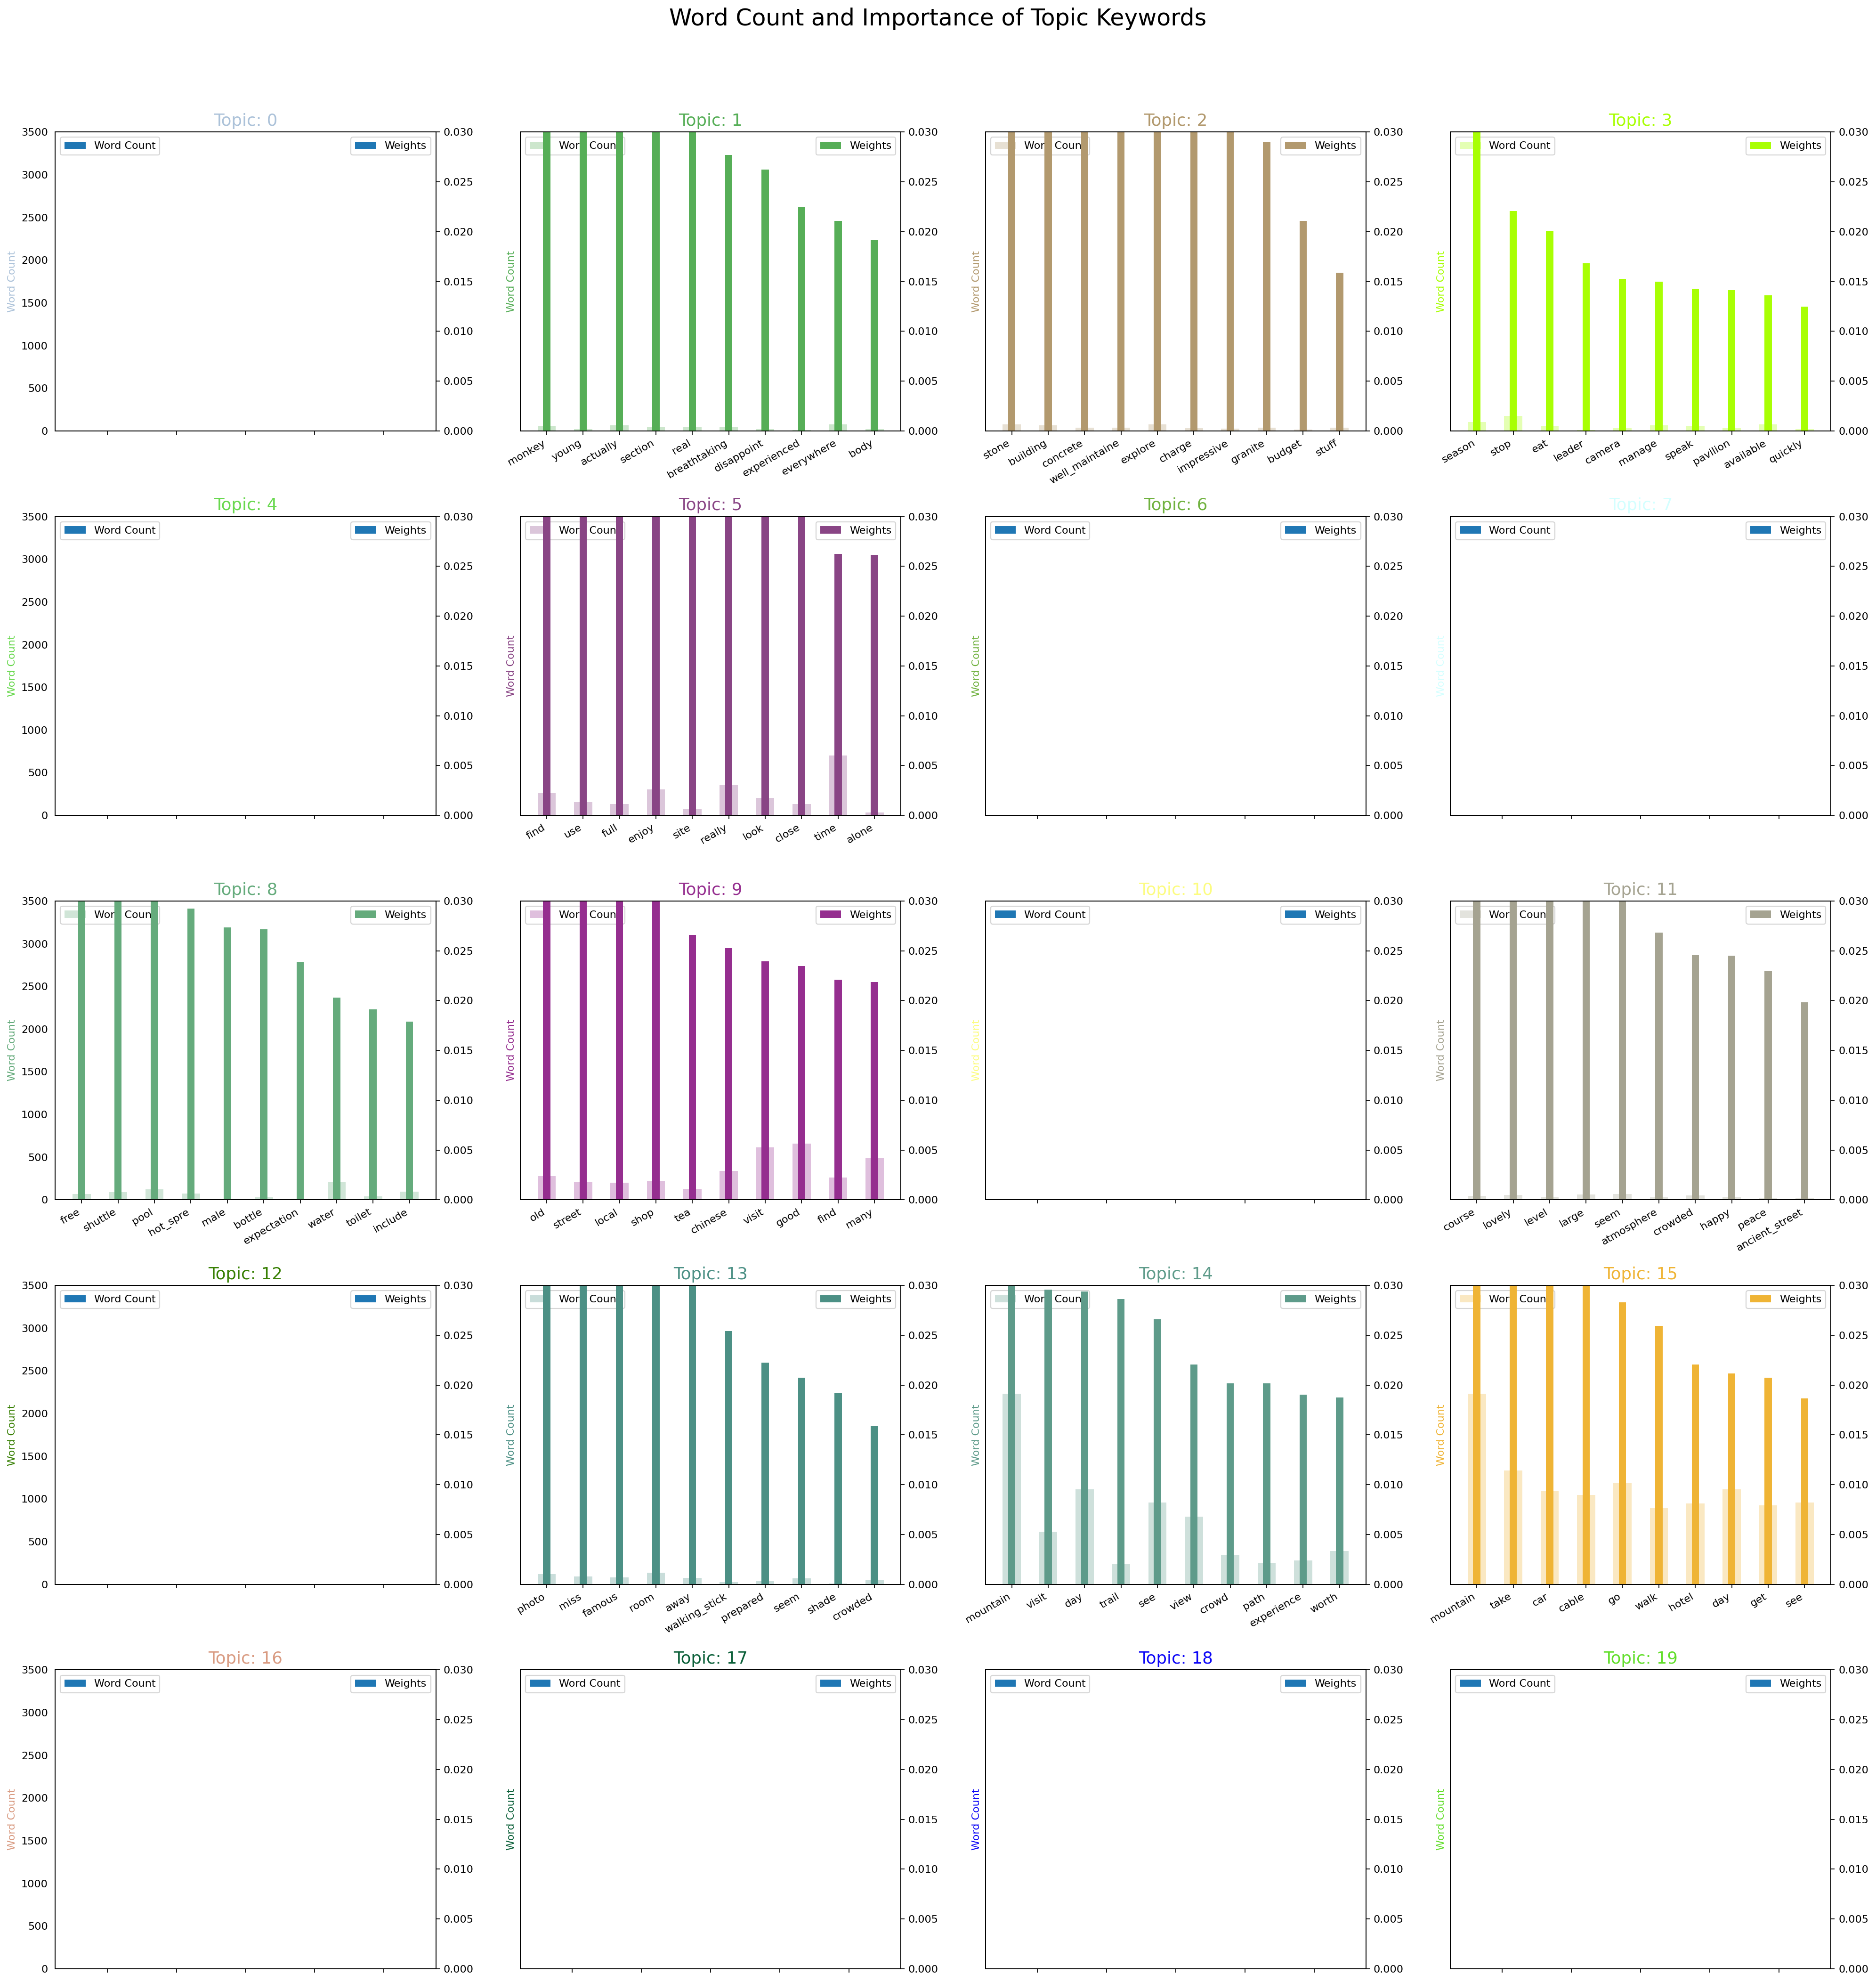

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 4, figsize=(25, 25), sharey=True, dpi=160)
##cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

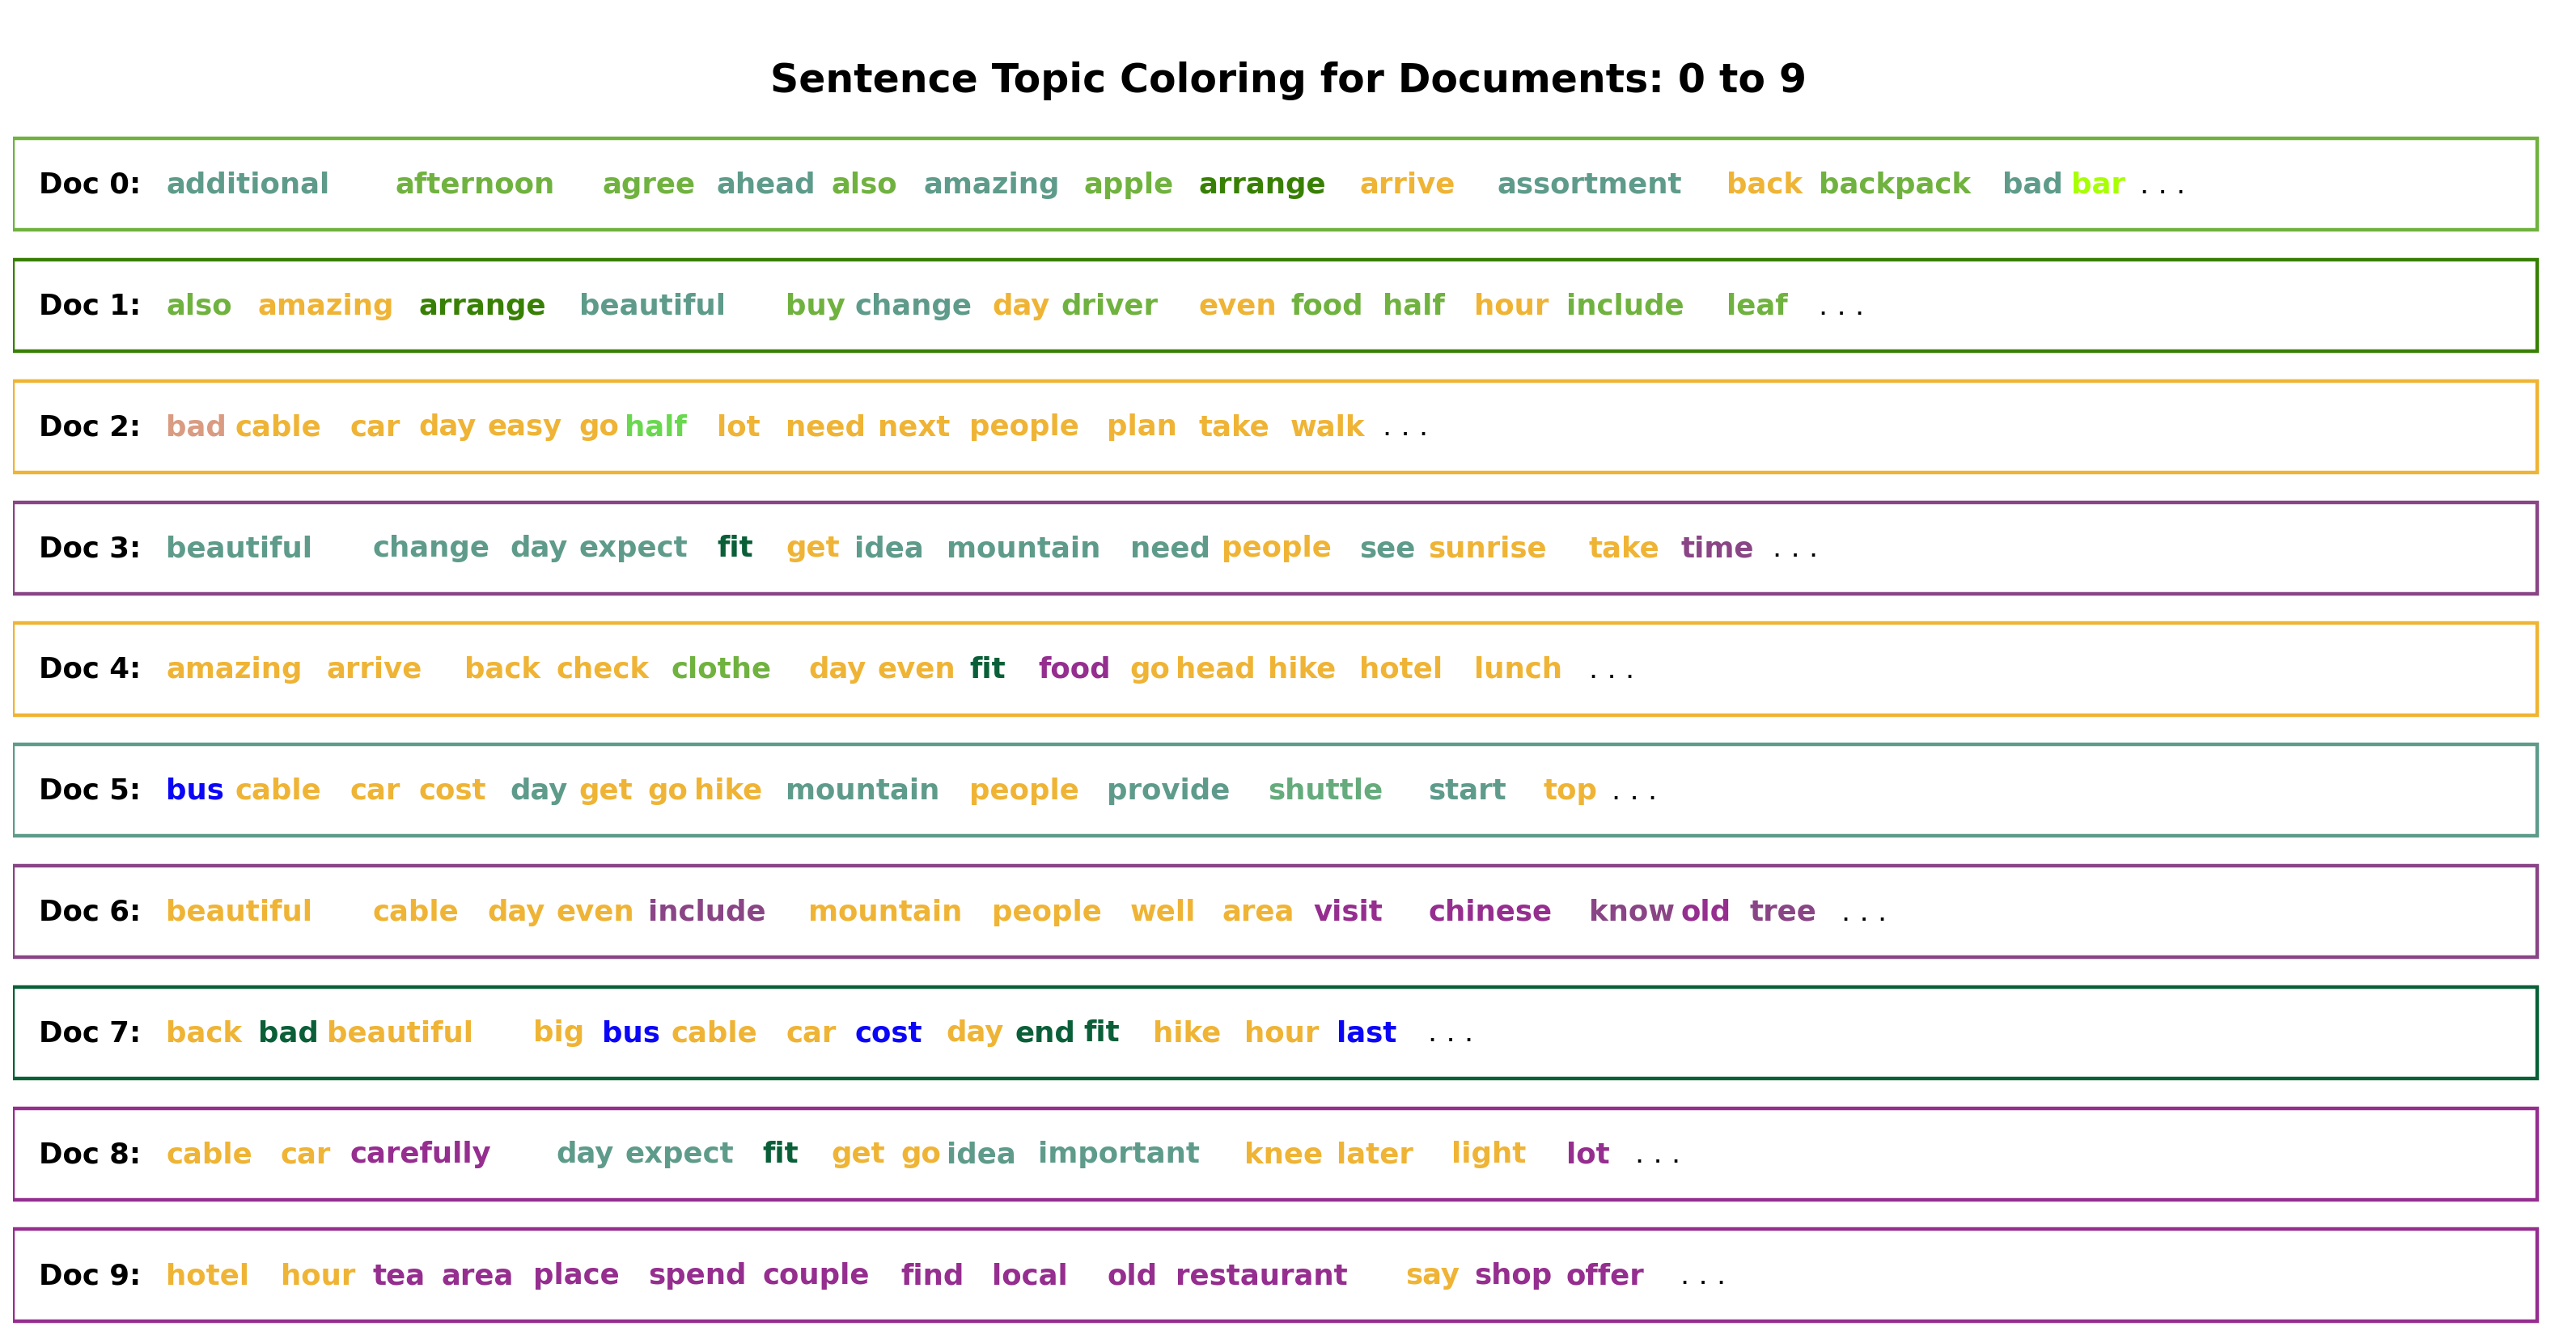

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 11):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.XKCD_COLORS.items()]
    ##cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    ##cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

IndexError: ignored

<Figure size 1200x480 with 2 Axes>

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 20
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1052 samples in 0.000s...
[t-SNE] Computed neighbors for 1052 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1052
[t-SNE] Computed conditional probabilities for sample 1052 / 1052
[t-SNE] Mean sigma: 0.100408
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.444847
[t-SNE] KL divergence after 1000 iterations: 0.391022


In [ ]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis


/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.391765  0.093217       1        1  40.026325
14     0.317926 -0.010555       2        1  12.371185
9      0.195691 -0.220439       3        1   6.217254
6      0.165993  0.246237       4        1   5.546581
3     -0.057901  0.092882       5        1   4.500817
5      0.040386 -0.128328       6        1   3.015058
4      0.019594 -0.164242       7        1   2.959205
17    -0.008745  0.070408       8        1   2.935575
16     0.007856 -0.159830       9        1   2.761557
18    -0.065508  0.005448      10        1   2.443422
8     -0.068615  0.098845      11        1   2.201337
13    -0.101851  0.015700      12        1   2.102666
10    -0.101030  0.020800      13        1   1.894880
2     -0.103185  0.002005      14        1   1.771185
12    -0.096420 -0.001849      15        1   1.733154
19    -0.096027  0.013052      16        1   1.700832
1     -0.101401  0.011133      17        1   1.669109
11    -0.120679  0.020873      18        1   1.525014
7     -0.101295 -0.006788      19        1   1.449778
0     -0.116556  0.001431      20        1   1.175065, topic_info=              Term         Freq        Total Category  logprob  loglift
24             bus   566.000000   566.000000  Default  30.0000  30.0000
98        mountain  1980.000000  1980.000000  Default  29.0000  29.0000
268          place   577.000000   577.000000  Default  28.0000  28.0000
153           take  1356.000000  1356.000000  Default  27.0000  27.0000
27             car  1257.000000  1257.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4468         haunt     5.221836     6.170188  Topic20  -5.3003   4.2770
3043     primarily     5.532176     6.541140  Topic20  -5.2426   4.2763
621     especially    22.685985   115.394267  Topic20  -3.8314   2.8172
5912      tracking     8.823288    26.536832  Topic20  -4.7758   3.3427
781   grand_canyon     8.187326    39.158764  Topic20  -4.8506   2.8788

[805 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5865      3  0.040779         aaron
5865      7  0.774798         aaron
5865     10  0.040779         aaron
5865     11  0.040779         aaron
5865     16  0.040779         aaron
...     ...       ...           ...
601       7  0.939819          yuan
899      14  0.974574         yungu
1379     10  0.924114  yungu_temple
560       6  0.967931          yupe
561       6  0.975259        yuping

[896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 15, 10, 7, 4, 6, 5, 18, 17, 19, 9, 14, 11, 3, 13, 20, 2, 12, 8, 1])

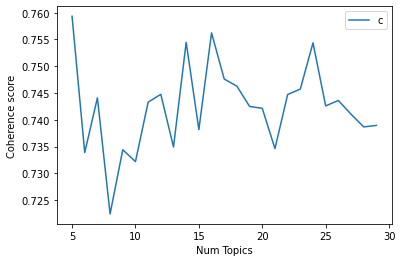

Num Topics = 5  has Coherence Value of 0.7593
Num Topics = 6  has Coherence Value of 0.7339
Num Topics = 7  has Coherence Value of 0.7441
Num Topics = 8  has Coherence Value of 0.7224
Num Topics = 9  has Coherence Value of 0.7344
Num Topics = 10  has Coherence Value of 0.7322
Num Topics = 11  has Coherence Value of 0.7433
Num Topics = 12  has Coherence Value of 0.7448
Num Topics = 13  has Coherence Value of 0.7349
Num Topics = 14  has Coherence Value of 0.7545
Num Topics = 15  has Coherence Value of 0.7382
Num Topics = 16  has Coherence Value of 0.7562
Num Topics = 17  has Coherence Value of 0.7476
Num Topics = 18  has Coherence Value of 0.7463
Num Topics = 19  has Coherence Value of 0.7425
Num Topics = 20  has Coherence Value of 0.7421
Num Topics = 21  has Coherence Value of 0.7346
Num Topics = 22  has Coherence Value of 0.7447
Num Topics = 23  has Coherence Value of 0.7457
Num Topics = 24  has Coherence Value of 0.7544
Num Topics = 25  has Coherence Value of 0.7426
Num Topics = 26  h

In [ ]:




# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix

'''
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])
    
    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text] 

##
##def remove_stopwords(texts):
  ##for text in texts:
    ##return [word for word in simple_preprocess(str(text)) if word not in stop_words] 
##

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

'''

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word, 
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500) 
                                                 ##iterations=1500)   
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        model_list.append(model)   

        
         
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=30, step=1)



import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=5; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

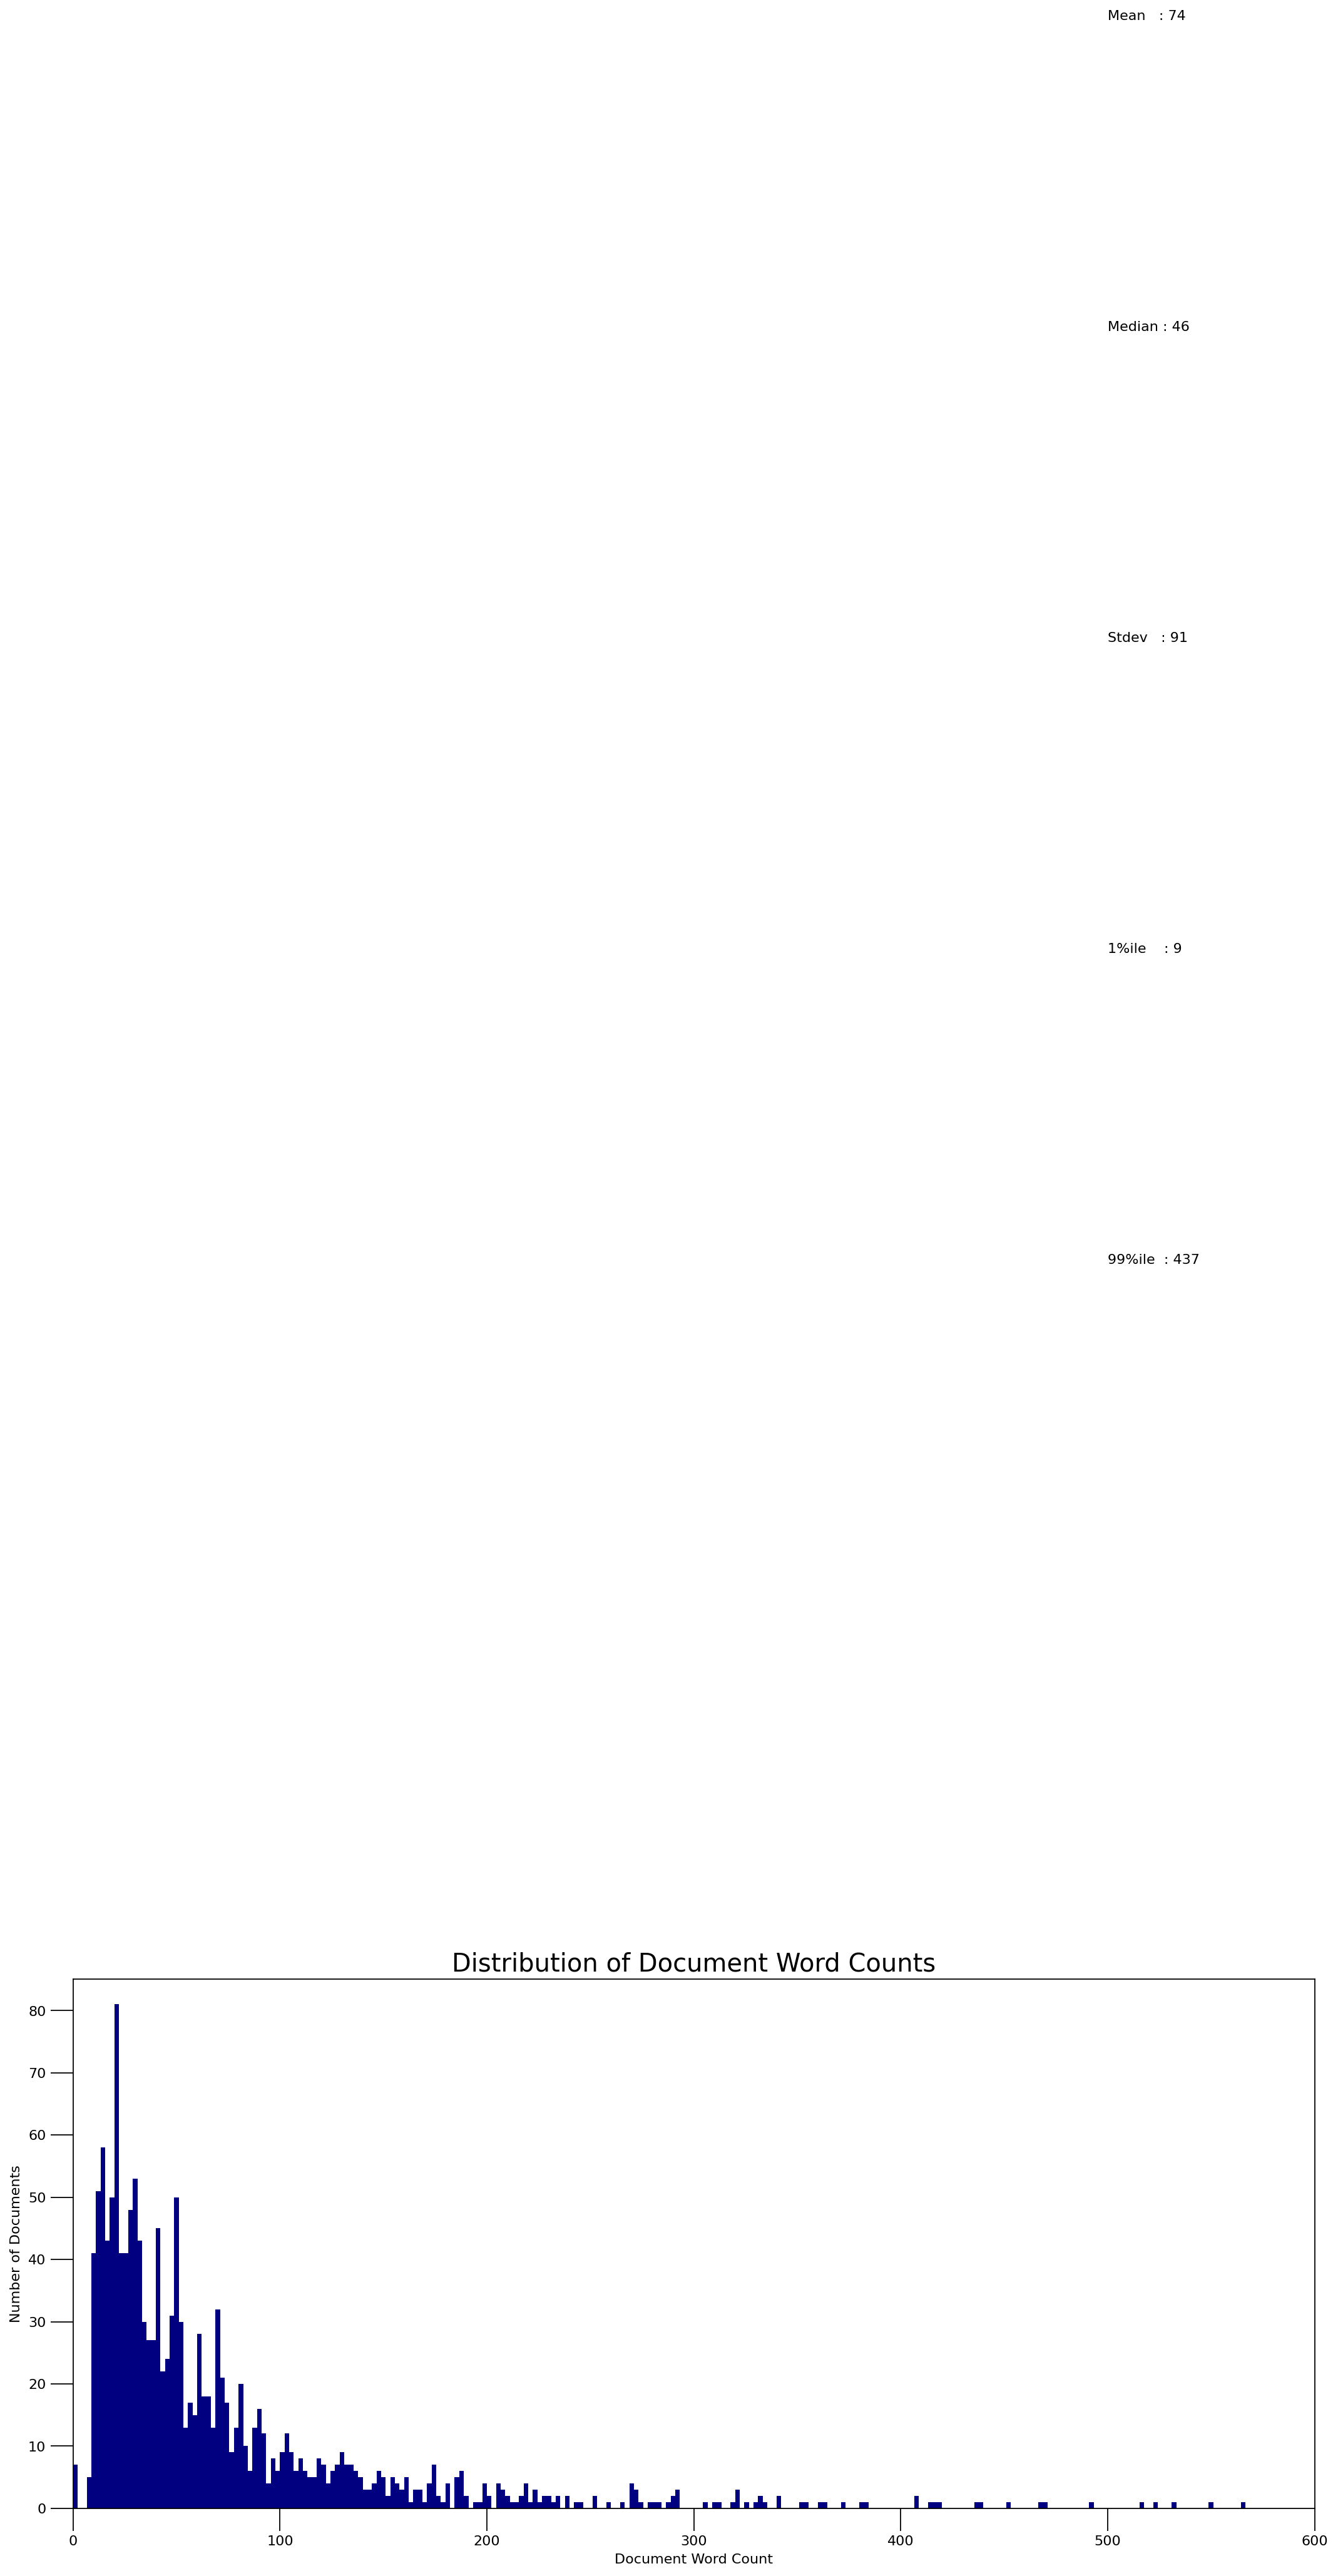

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.000181  0.000857       1        1  39.739386
6      0.000554 -0.000750       2        1  14.442839
7     -0.000715  0.000495       3        1  11.017273
0     -0.000821 -0.000504       4        1   9.488139
4      0.000402 -0.000123       5        1   6.793905
3      0.000318  0.000269       6        1   5.731090
9     -0.000121  0.000331       7        1   4.057124
2      0.000404 -0.000317       8        1   2.543931
1     -0.000627 -0.000507       9        1   2.431022
8      0.000395  0.000023      10        1   2.256243
5      0.000029  0.000226      11        1   1.499048, topic_info=              Term       Freq      Total Category  logprob  loglift
5813           che  16.000000  16.000000  Default  30.0000  30.0000
3284     comparing  15.000000  15.000000  Default  29.0000  29.0000
5134          vibe  14.000000  14.000000  Default  28.0000  28.0000
5923       opposed  14.000000  14.000000  Default  27.0000  27.0000
5319    unbearable  14.000000  14.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
6127       incline   0.269502  14.422861  Topic11  -8.7039   0.2203
7378          woud   0.269718  14.539670  Topic11  -8.7031   0.2131
6788  sufficiently   0.270450  14.856538  Topic11  -8.7004   0.1942
7241         reuse   0.268609  14.387315  Topic11  -8.7072   0.2195
7411        maddie   0.268816  15.104597  Topic11  -8.7065   0.1716

[558 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4851      1  0.367214        aback
4851      2  0.146886        aback
4851      3  0.073443        aback
4851      4  0.073443        aback
4851      5  0.073443        aback
...     ...       ...          ...
2317      3  0.071818  zhangjiajie
2317      4  0.071818  zhangjiajie
2317      5  0.071818  zhangjiajie
2317      6  0.071818  zhangjiajie
2317      7  0.071818  zhangjiajie

[3664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 8, 1, 5, 4, 10, 3, 2, 9, 6])

In [ ]:


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()



# Select the model and print the topics
optimal_model = model_list[6]


# Finding the dominant topic in each document 

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(20)

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 600, color='navy')
plt.text(500, 400, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(500, 350, "Median : " + str(round(np.median(doc_lens))))
plt.text(500, 300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(500, 250, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(500, 200, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 600), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,600,7))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()


# Visualize the topics
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis


In [ ]:
print(df.shape)

NameError: ignored

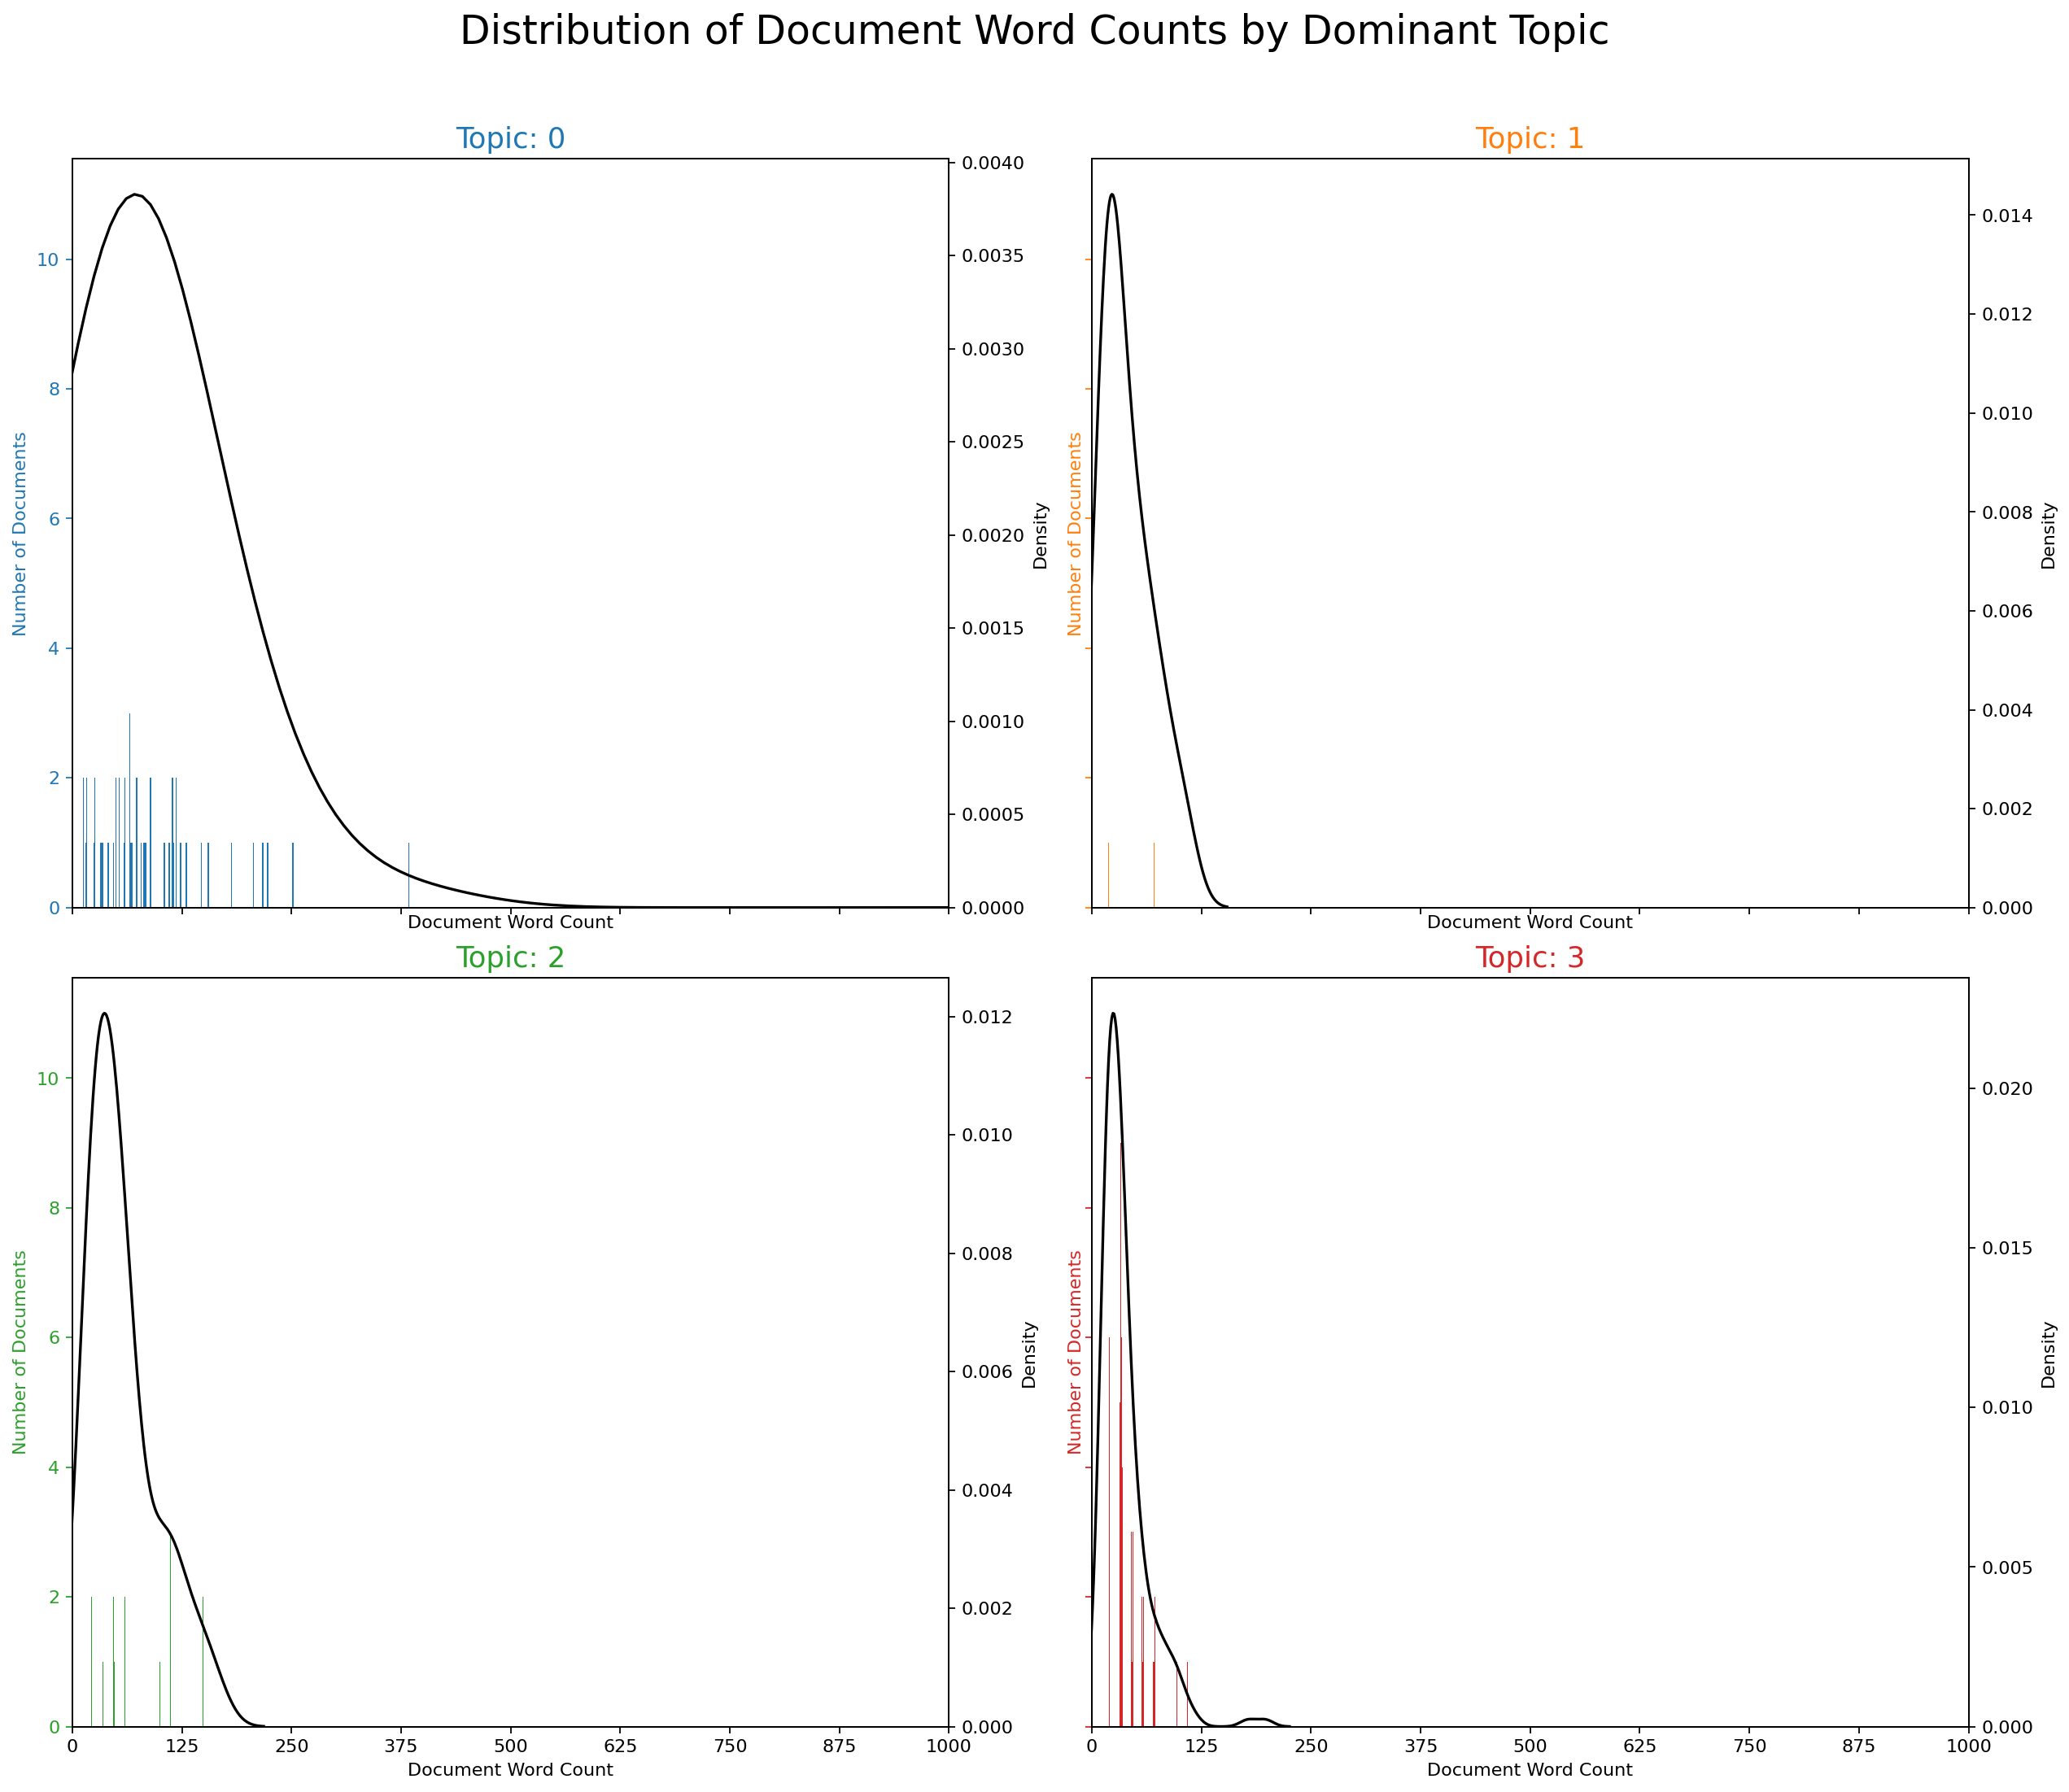

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


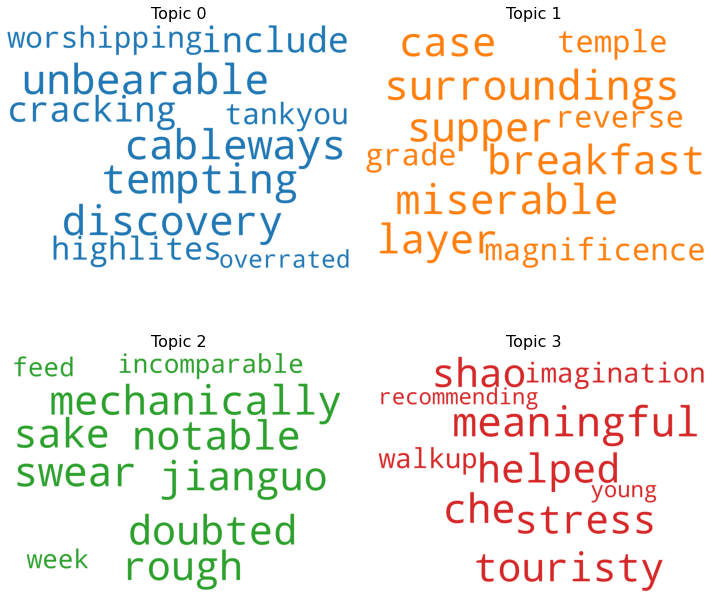

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

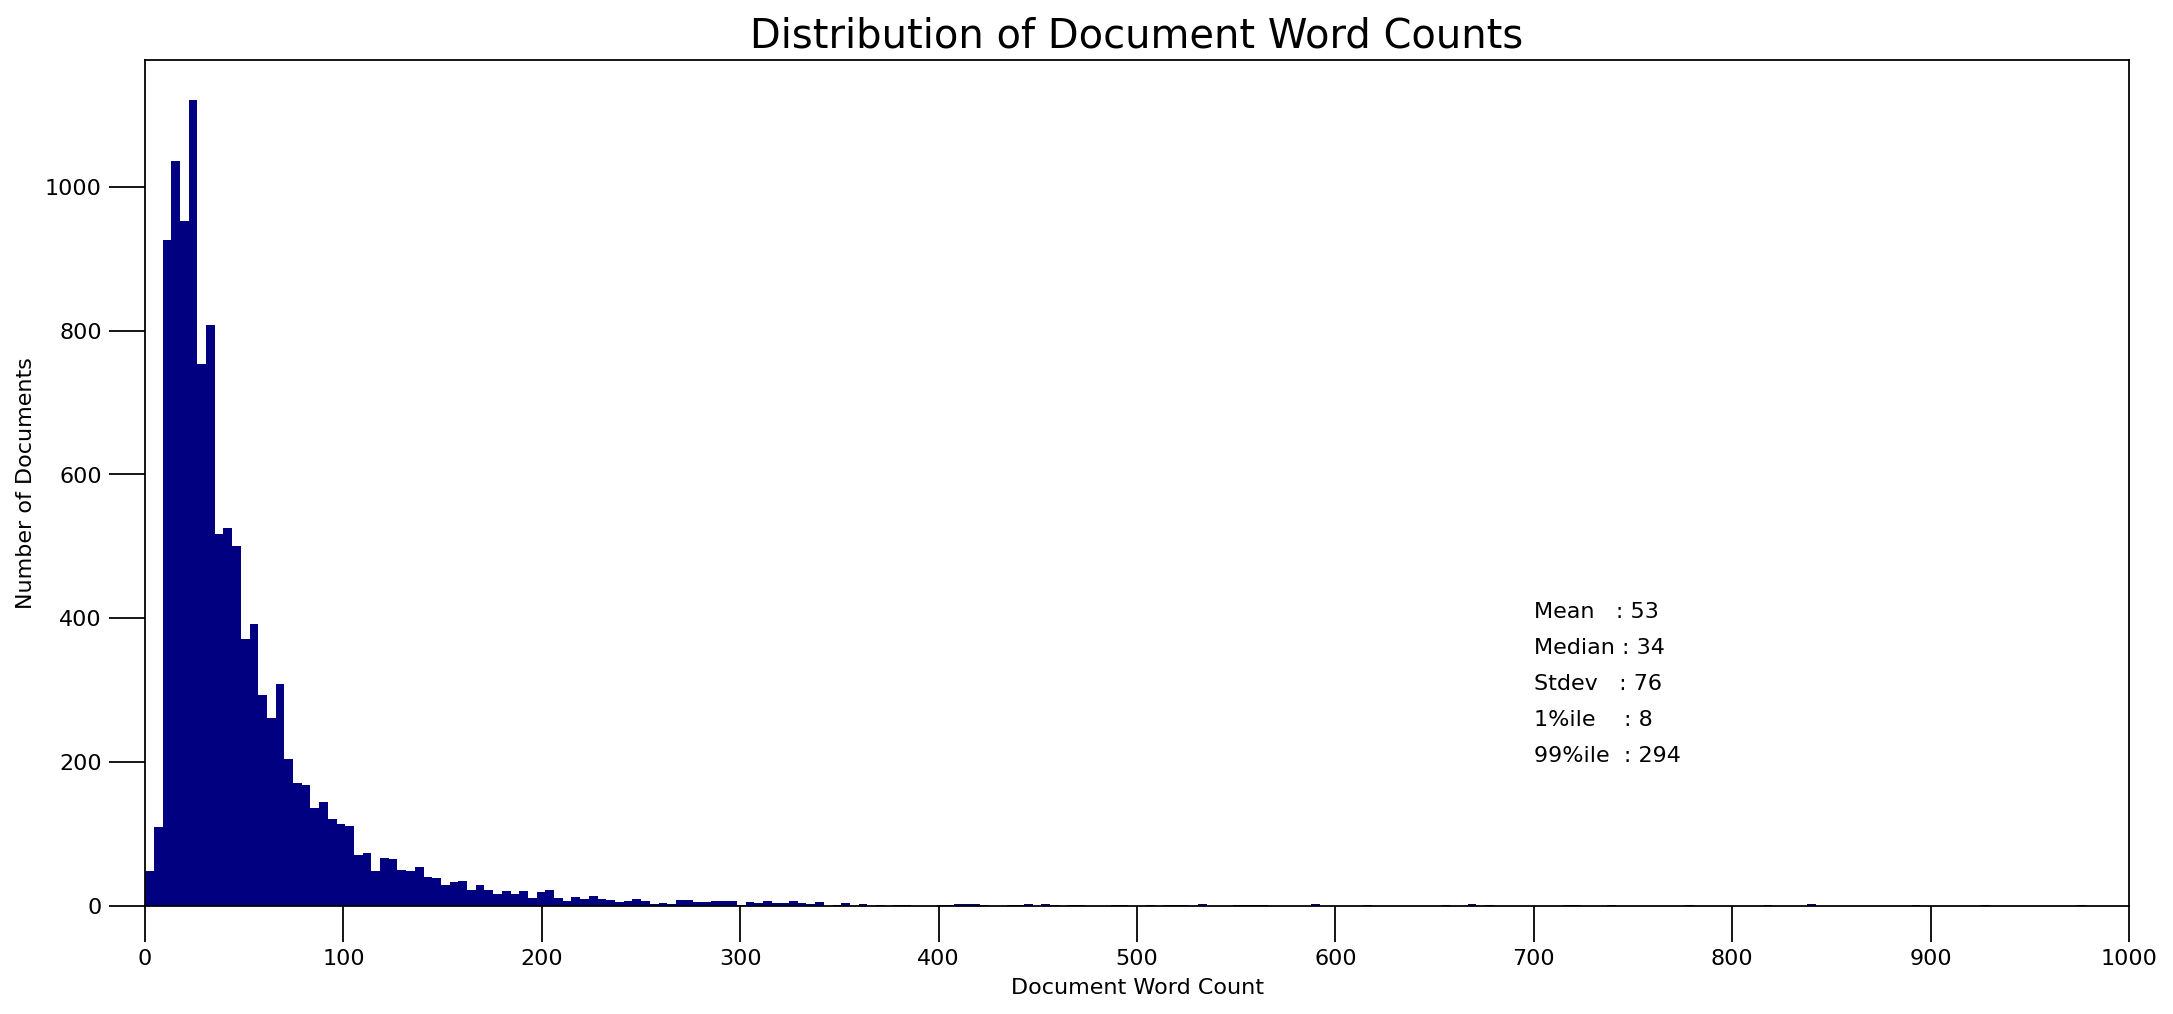

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
1     -0.000342  1.893269e-05       1        1  25.351977
2     -0.000114  5.908157e-04       2        1  15.239781
3      0.000079  2.625780e-05       3        1  14.535029
0     -0.000440  5.315694e-06       4        1  12.454172
8      0.000813 -5.612022e-07       5        1   9.441735
10     0.000895 -6.367755e-04       6        1   5.978421
6     -0.000441 -6.092325e-04       7        1   4.320621
9     -0.000298 -2.745909e-04       8        1   4.174067
4     -0.000465 -3.730311e-04       9        1   3.434634
7      0.000284  3.303005e-04      10        1   3.355337
5      0.000028  9.225687e-04      11        1   1.714226, topic_info=               Term       Freq      Total Category  logprob  loglift
14966      trickier  34.000000  34.000000  Default  30.0000  30.0000
16045      cascaded  34.000000  34.000000  Default  29.0000  29.0000
15615          prmd  35.000000  35.000000  Default  28.0000  28.0000
4385        buiding  32.000000  32.000000  Default  27.0000  27.0000
8250         tennis  33.000000  33.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
15272  huangshanbei   0.783515  36.889095  Topic11  -9.4721   0.2143
15050    sculptured   0.780273  37.088980  Topic11  -9.4763   0.2048
1097     frightened   0.764453  35.040829  Topic11  -9.4968   0.2411
16189          woma   0.769171  37.308886  Topic11  -9.4906   0.1845
2463     deshengmen   0.762873  34.796615  Topic11  -9.4988   0.2460

[541 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
13165      1  0.244156     absorbed
13165      2  0.183117     absorbed
13165      3  0.122078     absorbed
13165      4  0.091559     absorbed
13165      5  0.091559     absorbed
...      ...       ...          ...
10240      7  0.057699  zithromycin
10240      8  0.028850  zithromycin
10240      9  0.028850  zithromycin
10240     10  0.028850  zithromycin
10240     11  0.028850  zithromycin

[5739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 9, 11, 7, 10, 5, 8, 6])

In [ ]:


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()



# Select the model and print the topics
optimal_model = model_list[6]


# Finding the dominant topic in each document 

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(20)

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 600, color='navy')
plt.text(500, 400, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(500, 350, "Median : " + str(round(np.median(doc_lens))))
plt.text(500, 300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(500, 250, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(500, 200, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 600), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,600,7))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()


# Visualize the topics
#pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis


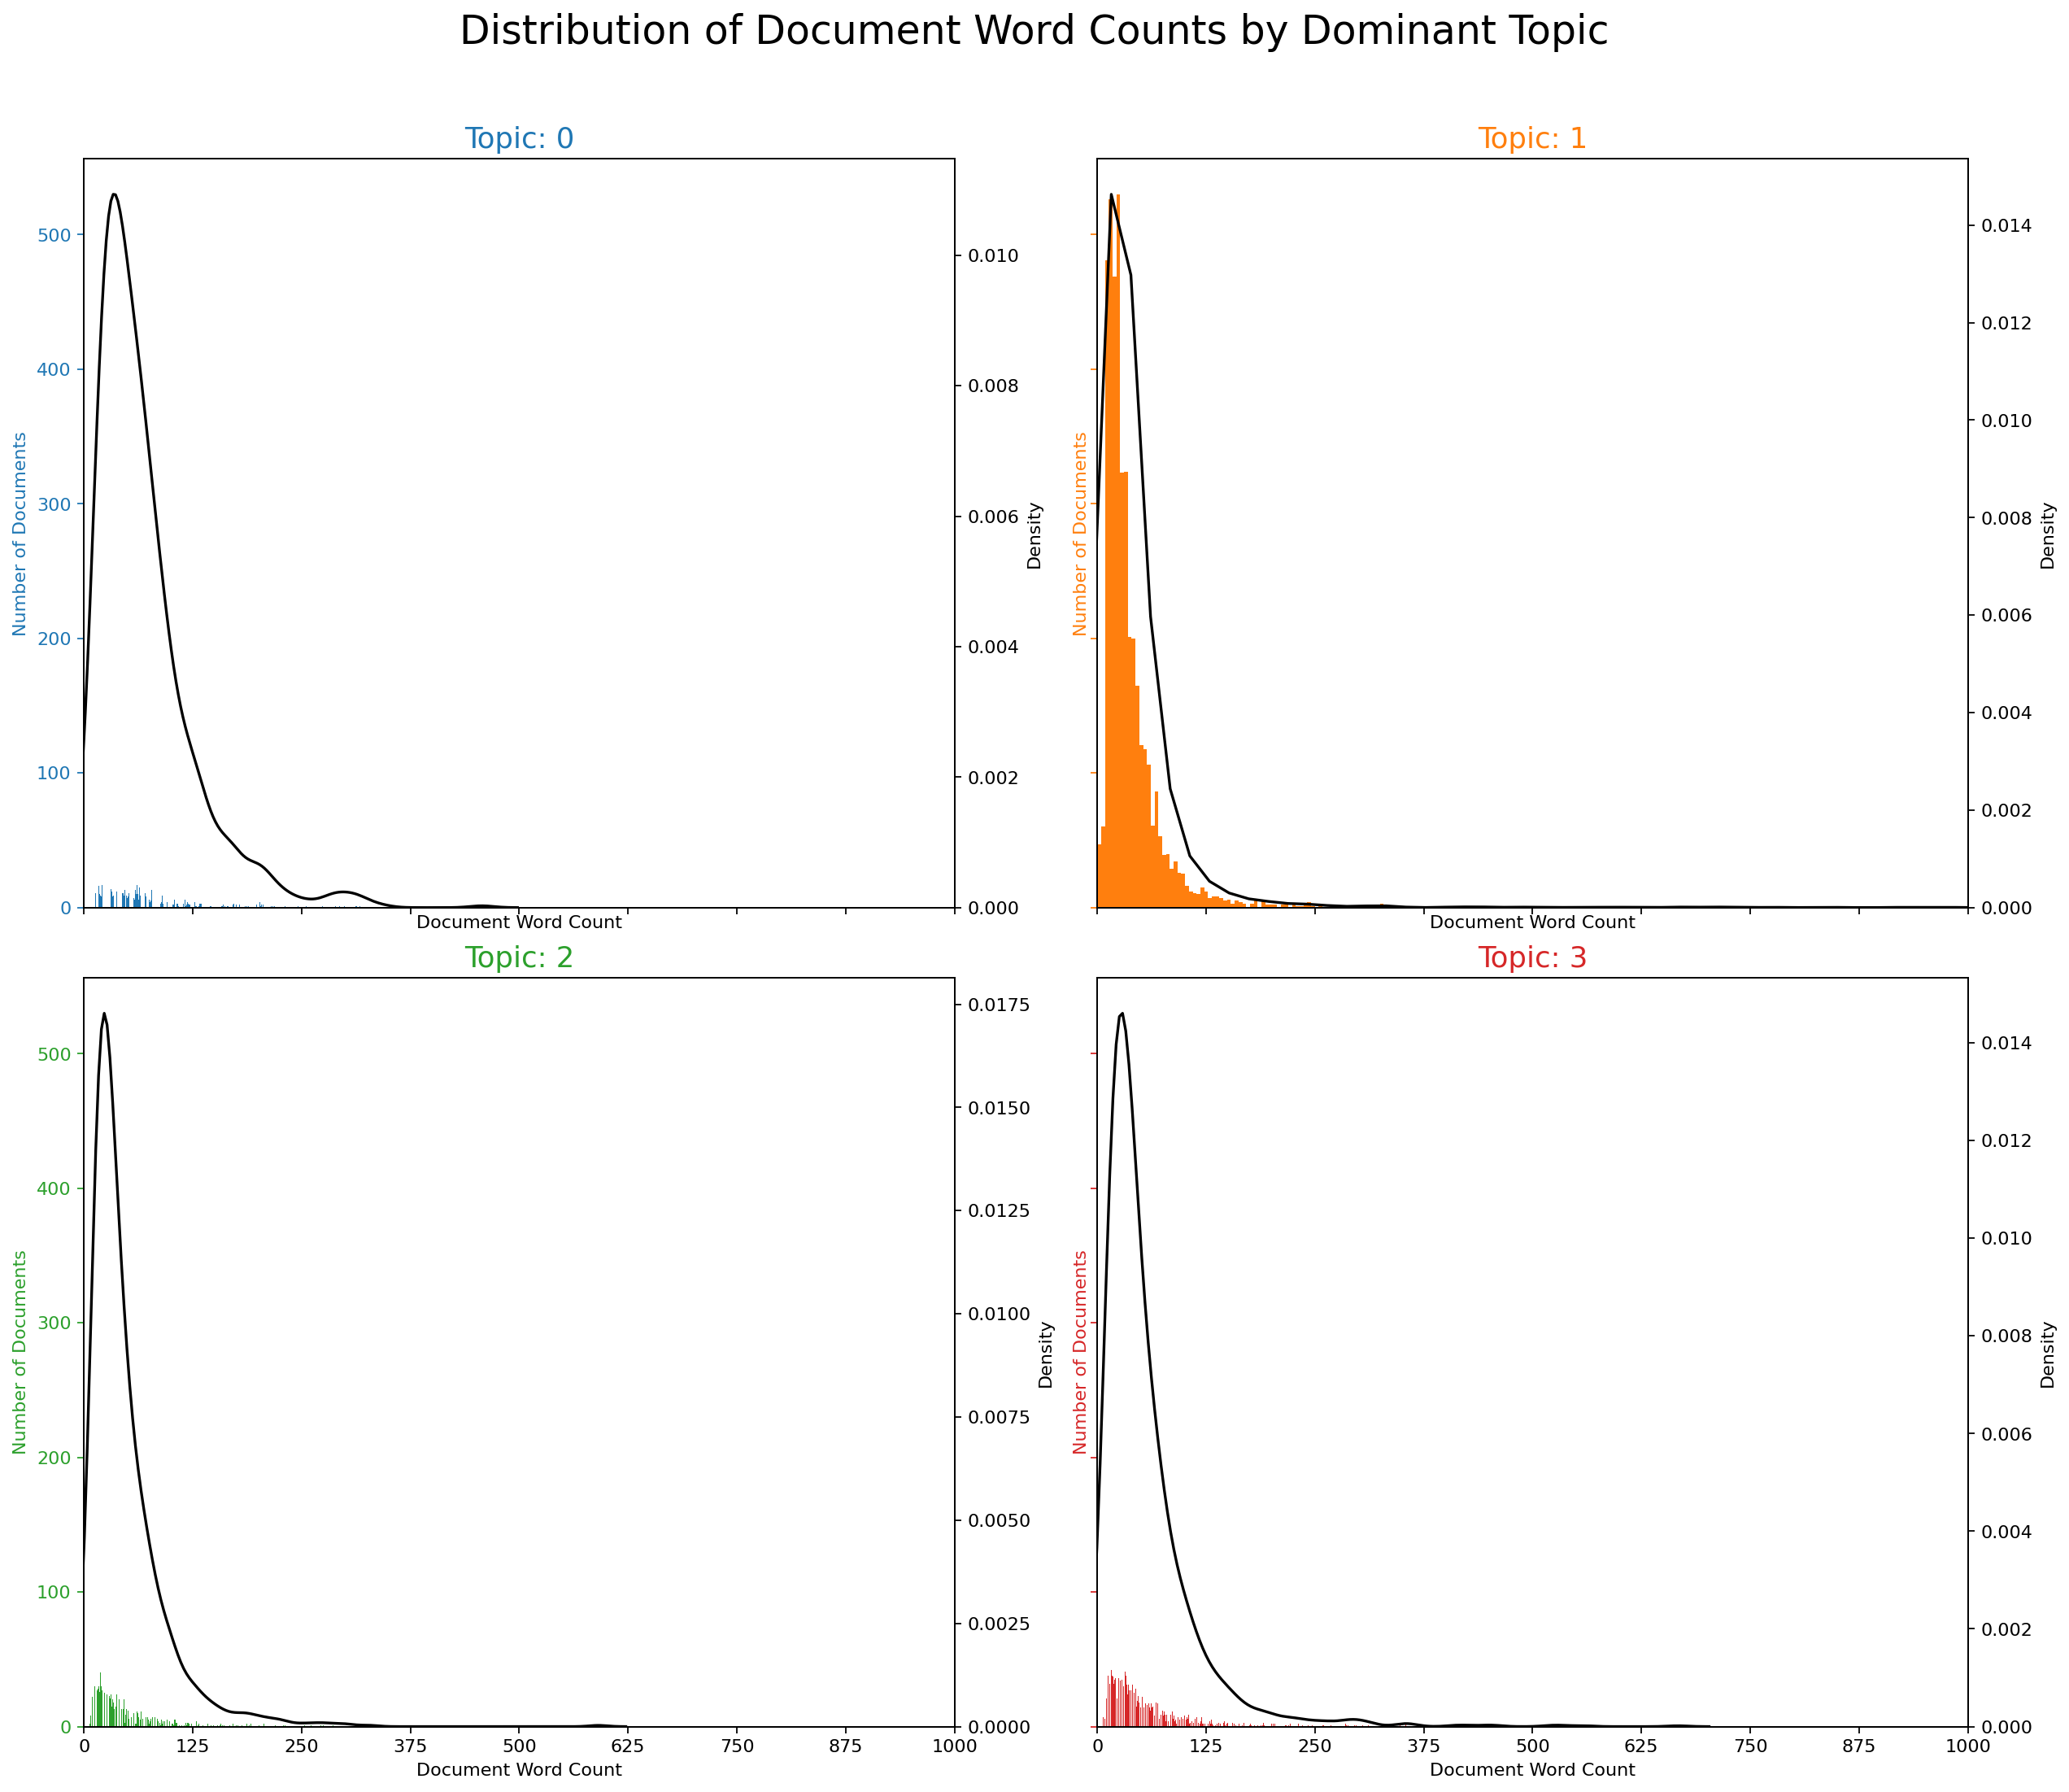

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


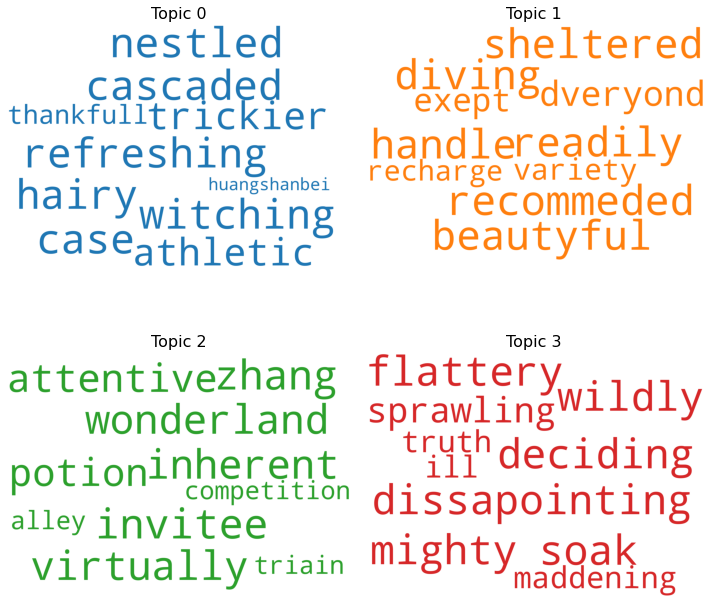

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

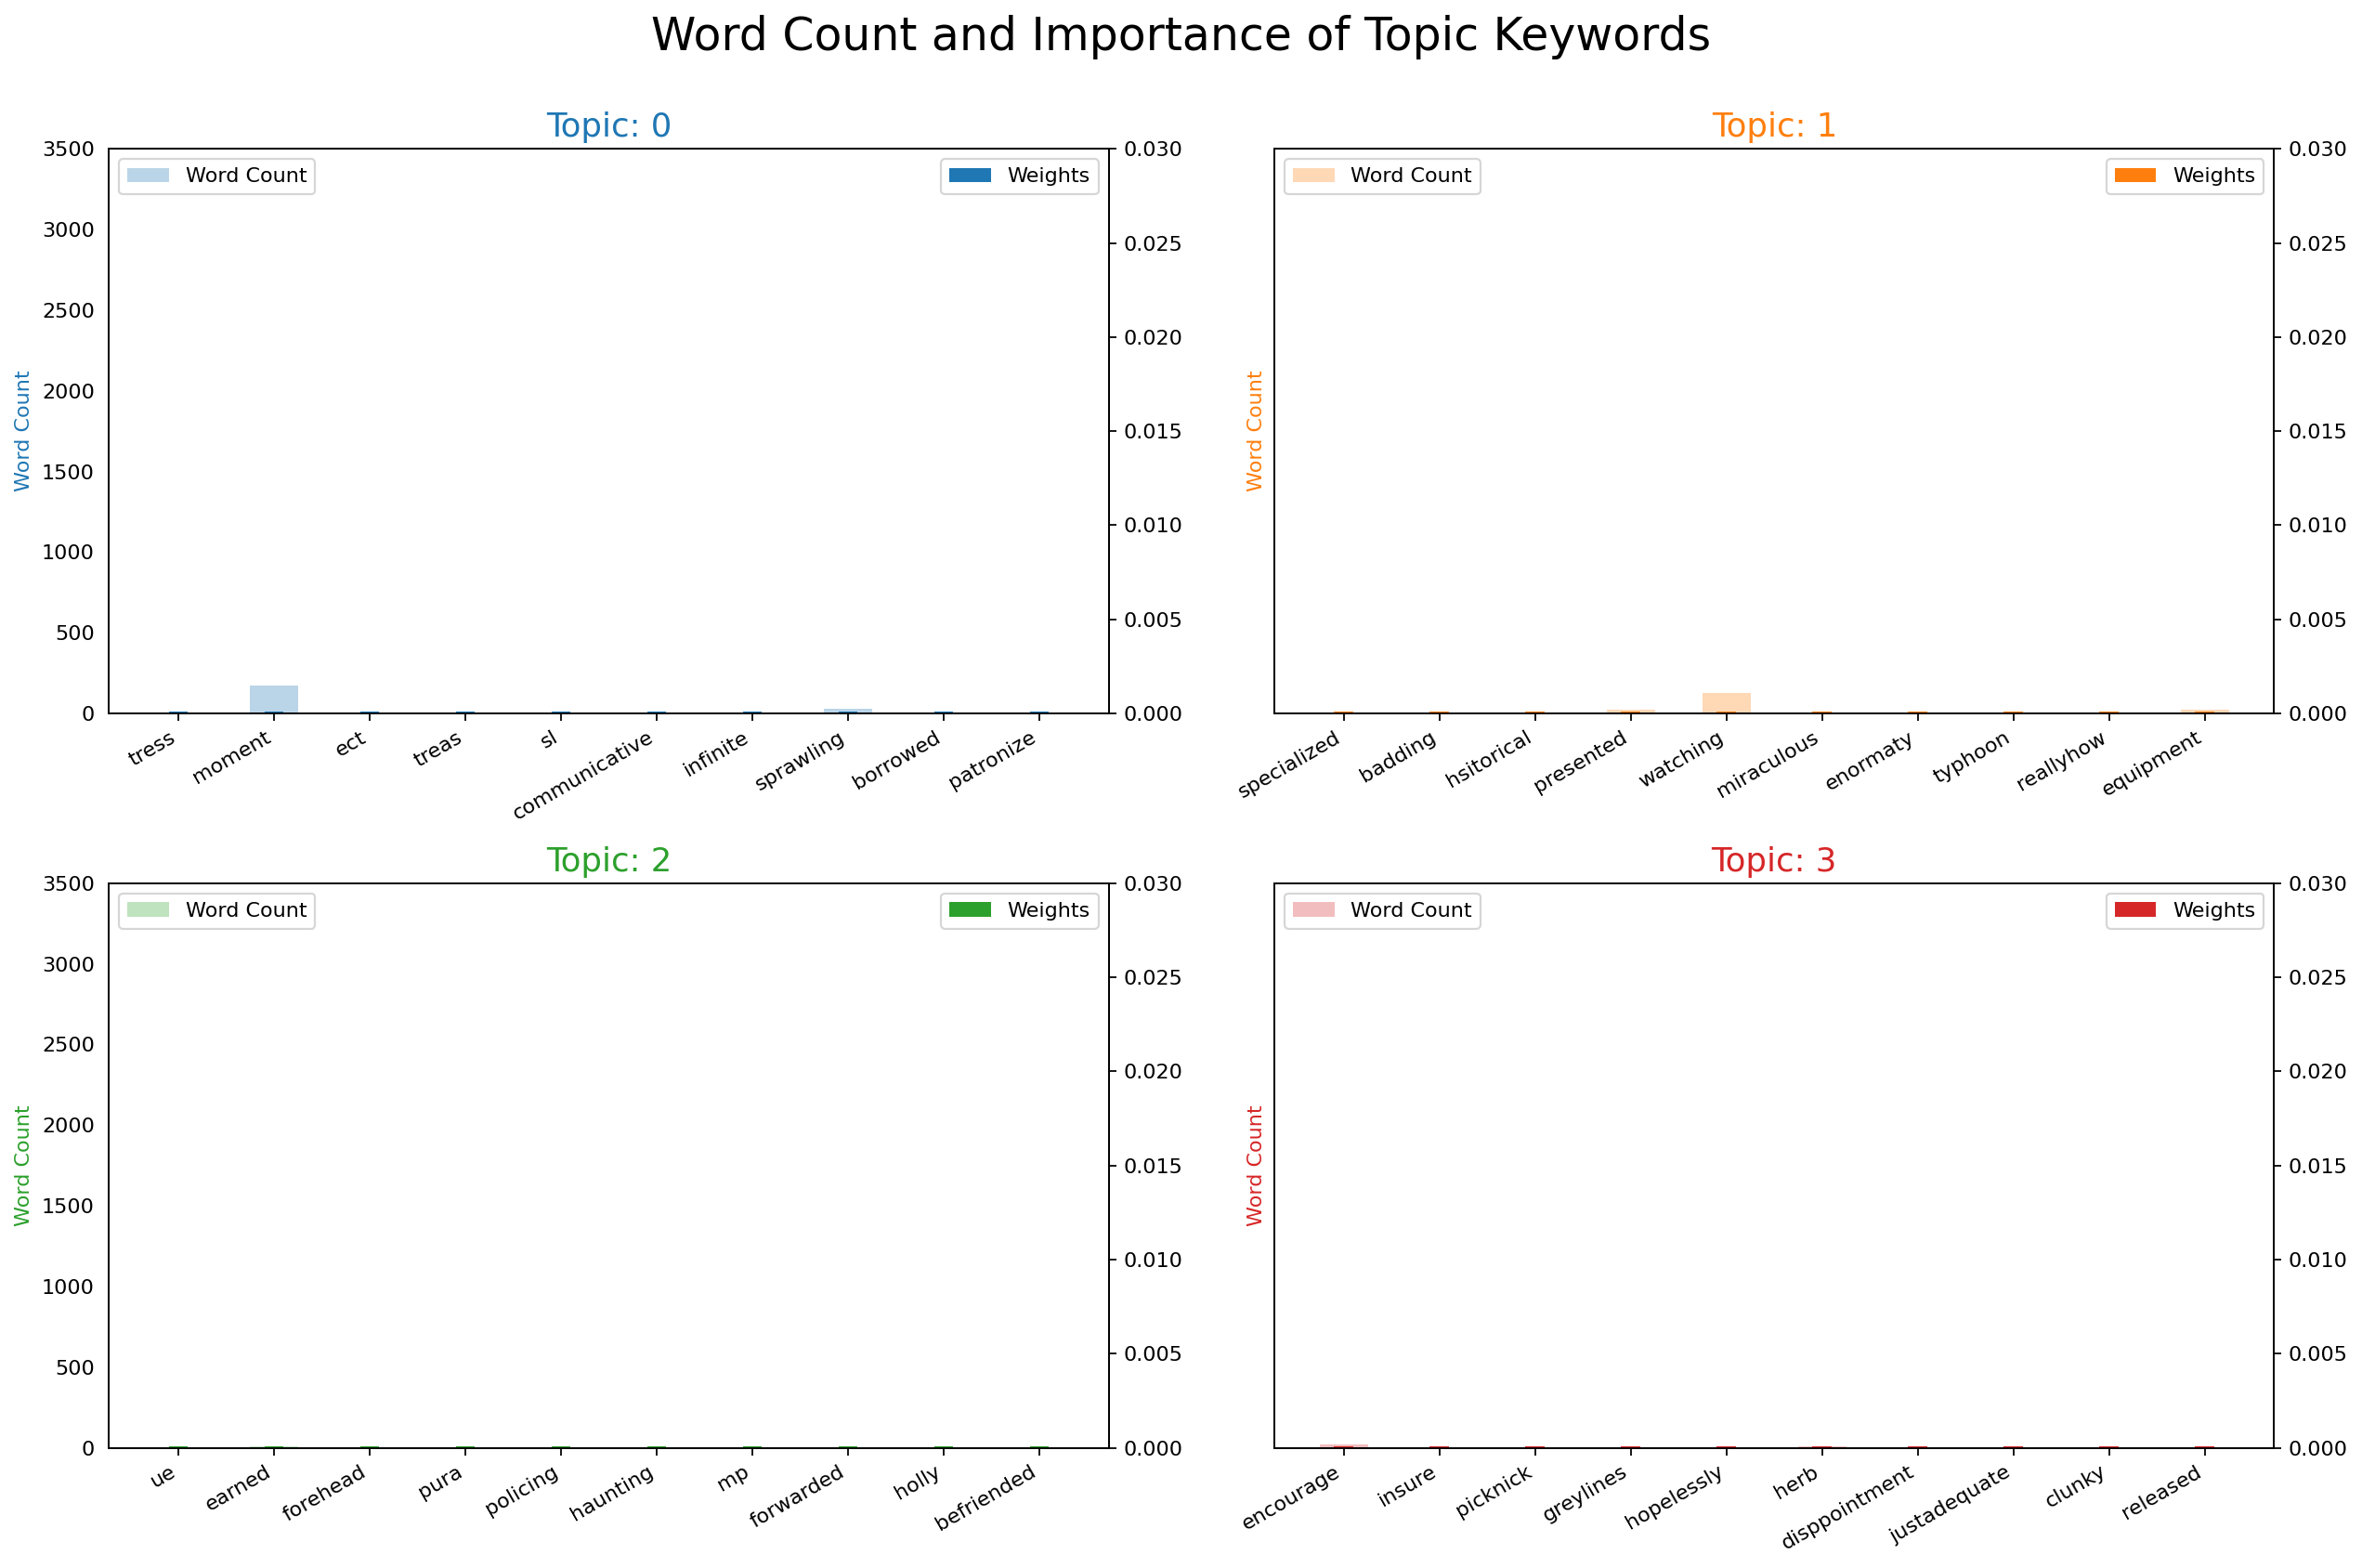

TypeError: ignored

In [ ]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

'''
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = optimal_model[corp_cur]
            word_dominanttopic = [(optimal_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  
'''
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
#for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:

from matplotlib.ticker import FuncFormatter

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)


# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

ValueError: ignored

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

TypeError: ignored

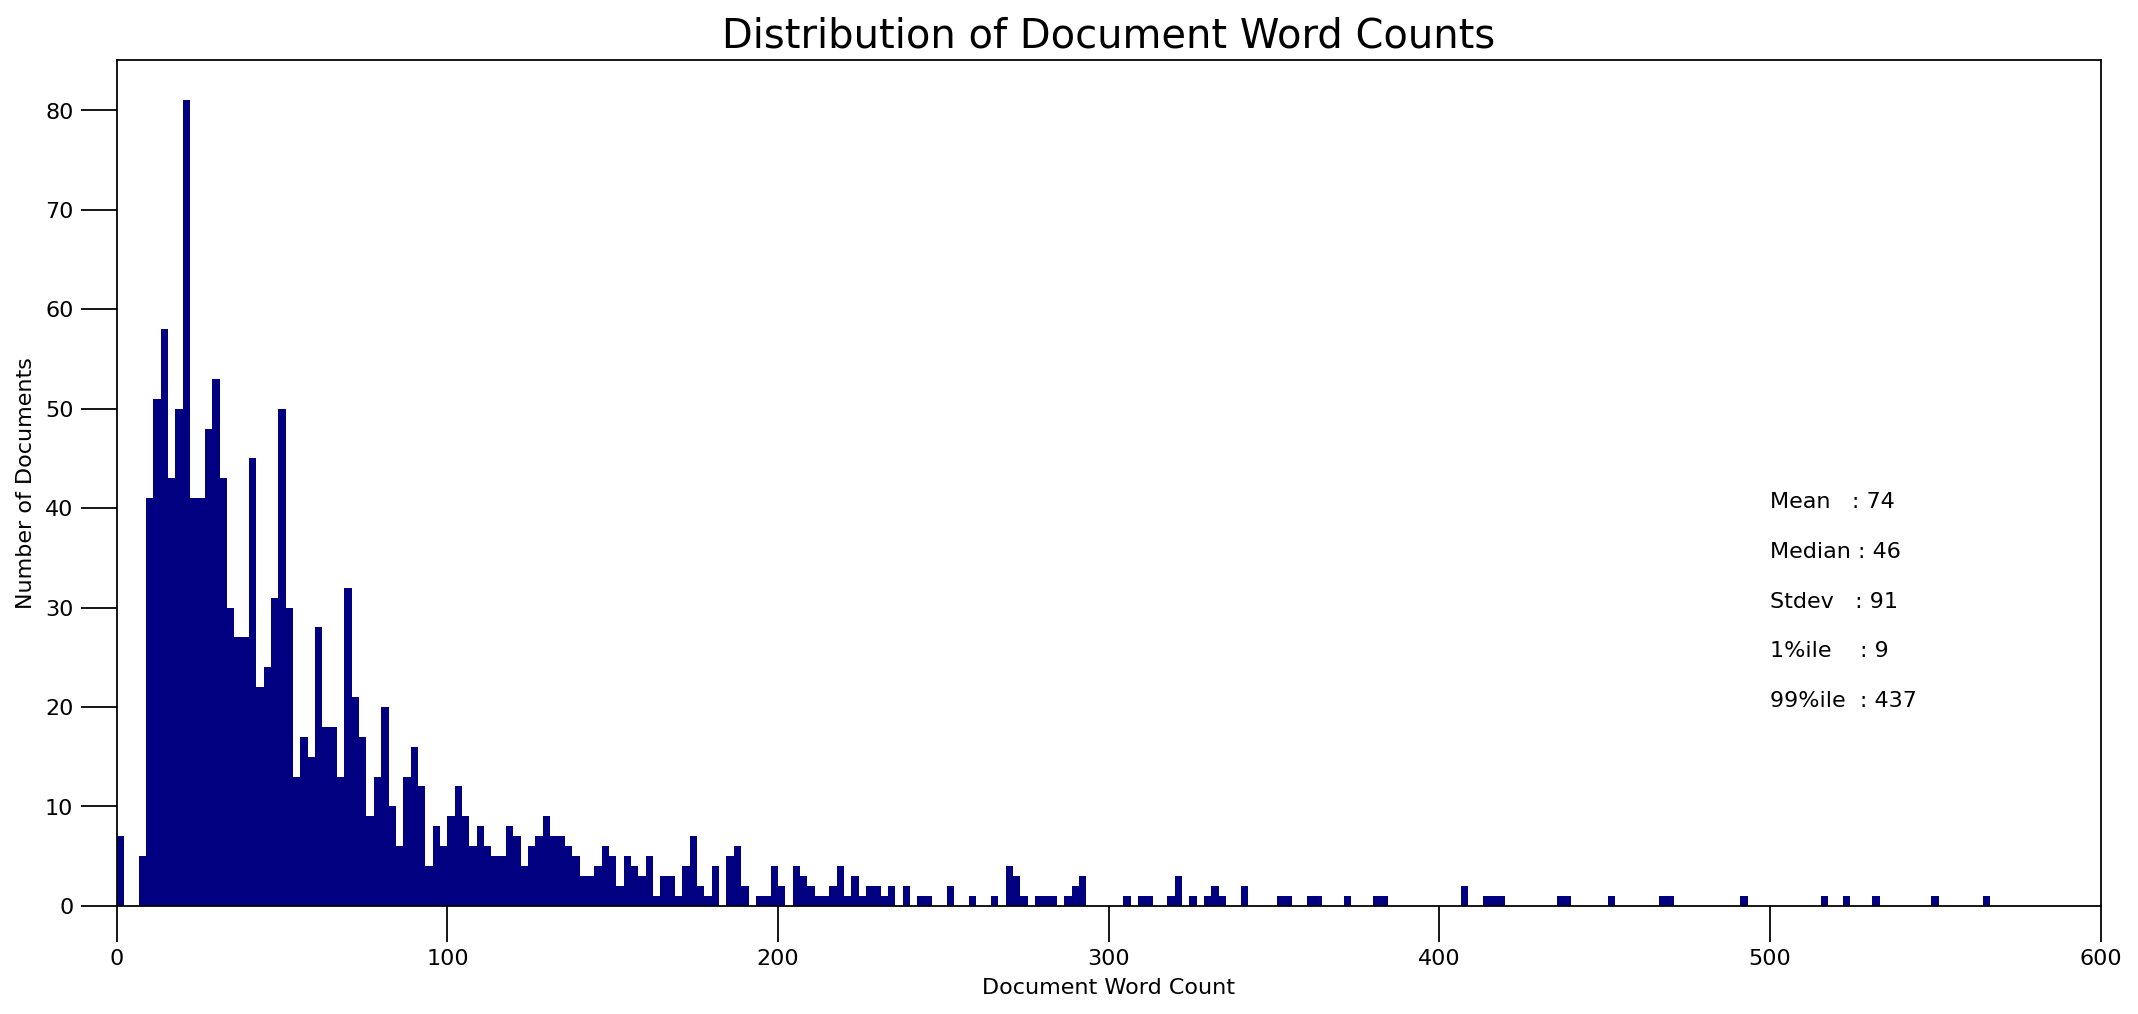

In [ ]:
# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 600, color='navy')
plt.text(500, 40, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(500, 35, "Median : " + str(round(np.median(doc_lens))))
plt.text(500, 30, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(500, 25, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(500, 20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 600), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,600,7))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()

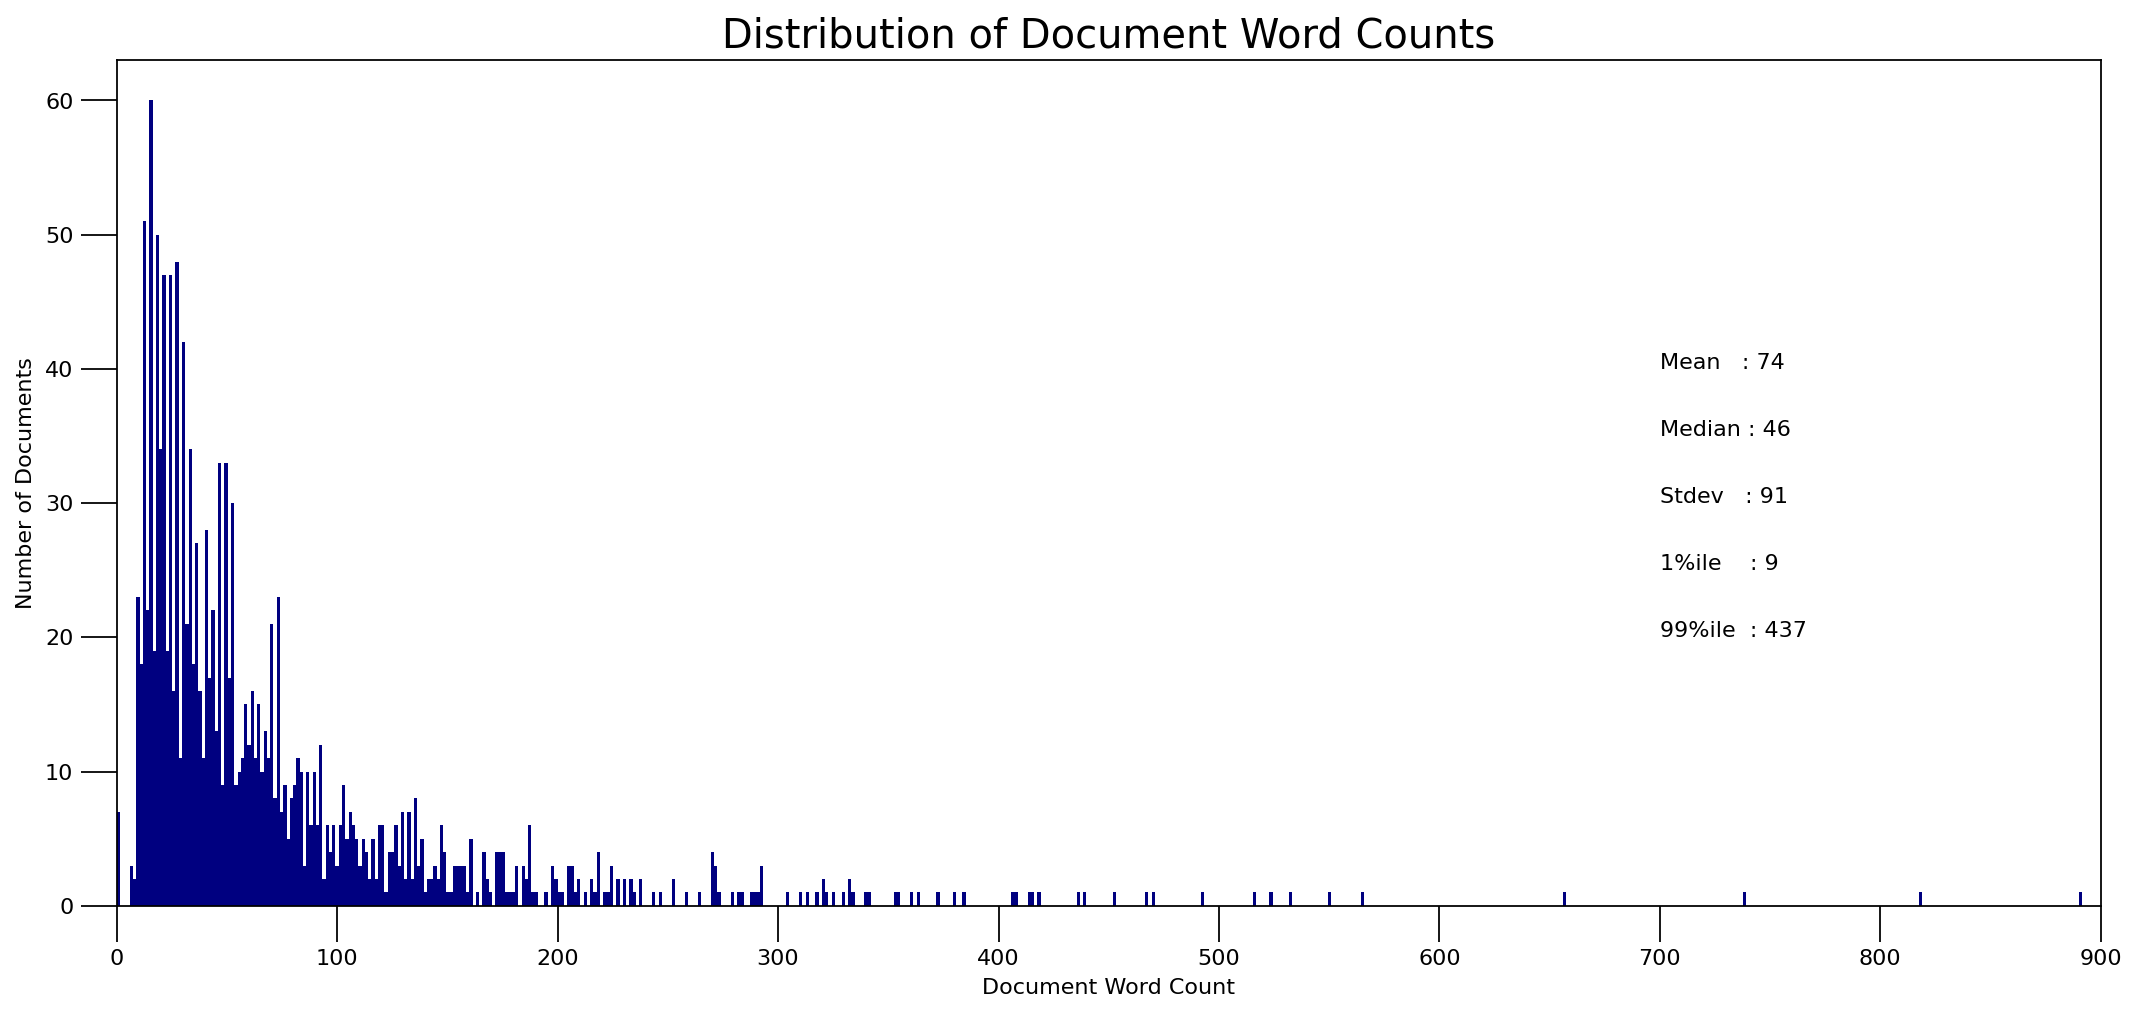

In [ ]:
# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 900, color='navy')
plt.text(700, 40, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(700, 35, "Median : " + str(round(np.median(doc_lens))))
plt.text(700, 30, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(700, 25, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(700, 20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()

In [ ]:

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word, 
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500) 
                                                 ##iterations=1500)   
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        model_list.append(model)   

        
         
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=30, step=1)



import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=5; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

In [ ]:
print(coherence_values[14])

0.7557361095372128


In [ ]:
imUsingColab = True

if imUsingColab:
    ##!pip install gensim
    !pip install pyLDAvis
    ##!pip install vega
    ##!pip install altair
    
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"  
!unzip -uq "/content/review_words.zip" -d "/content/"      

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
dirpath = '/content/review_words/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

import nltk

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])
    
    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text] 

'''
def remove_stopwords(texts):
  for text in texts:
    return [word for word in simple_preprocess(str(text)) if word not in stop_words] 
'''

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word, 
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500) 
                                                 ##iterations=1500)   
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        model_list.append(model)   

        
         
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=30, step=1)



import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=5; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

In [ ]:
# Select the model and print the topics
optimal_model = model_list[14]


# Finding the dominant topic in each document 

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(20)

Document_No  Dominant_Topic  Topic_Contrib  \
0             0            10.0         0.3432   
1             1             2.0         0.3267   
2             2             6.0         0.3295   
3             3            17.0         0.3721   
4             4             2.0         0.3614   
5             5             1.0         0.2847   
6             6            18.0         0.2859   
7             7            10.0         0.5624   
8             8             4.0         0.2675   
9             9            13.0         0.4571   
10           10             6.0         0.5200   
11           11            10.0         0.6239   
12           12             6.0         0.4204   
13           13             1.0         0.2405   
14           14            17.0         0.3085   
15           15            15.0         0.2793   
16           16            13.0         0.8119   
17           17             2.0         0.5911   
18           18            13.0         0.2879   
19           19            12.0         0.3803   

                                             Keywords  \
0   tiandu, idea, disliked, uninterrupted, shorten...   
1   backtracking, awestruck, mistake, kill, stunne...   
2   campsite, pitch, shortened, wont, camellia, is...   
3   regardless, safety, froze, lengthy, recycling,...   
4   backtracking, awestruck, mistake, kill, stunne...   
5   red, bunk, trek, waaaaaa, throwing, stamen, pl...   
6   confines, extravagant, zhaixi, solitude, cheap...   
7   tiandu, idea, disliked, uninterrupted, shorten...   
8   orderly, provision, frontage, biscuit, fading,...   
9   flea, yet, leisurelythan, overweight, furong, ...   
10  campsite, pitch, shortened, wont, camellia, is...   
11  tiandu, idea, disliked, uninterrupted, shorten...   
12  campsite, pitch, shortened, wont, camellia, is...   
13  red, bunk, trek, waaaaaa, throwing, stamen, pl...   
14  regardless, safety, froze, lengthy, recycling,...   
15  therapy, pouring, crook, used, versus, unavoid...   
16  flea, yet, leisurelythan, overweight, furong, ...   
17  backtracking, awestruck, mistake, kill, stunne...   
18  flea, yet, leisurelythan, overweight, furong, ...   
19  lump, pilgrimage, indoors, midday, product, ra...   

                                                 Text  \
0   [want, pay, cable, opt, hike, mountain, rememb...   
1   [jane, jane, jane, couching, tiger, hidden, dr...   
2   [easy, place, visit, without, knowing, chinese...   
3   [family, spent, day, huangshan, area, wonderfu...   
4   [booked, private, tour, china, highlight, webs...   
5   [like, crowd, go, week, day, avoid, golden, we...   
6   [cool, one, thousand, beautiful, tree, mountai...   
7   [t, trip, huangshan, travelled, beijing, huang...   
8   [never, seen, elsewhere, misty, clear, still, ...   
9   [old, stree, hotel, fun, place, spend, couple,...   
10  [never, seen, anything, like, place, easy, get...   
11  [main, objective, many, chinese, visitor, come...   
12  [sea, cloud, imo, huangshan, beautiful, mounta...   
13  [mountain, climbing, engaged, regular, exercis...   
14  [one, popular, mountain, china, brings, millio...   
15  [mt, huangshan, beautiful, national, park, sun...   
16  [tunxi, ancient, shopping, street, well, prese...   
17  [experience, yellow, mountain, truly, spectacu...   
18  [toured, many, old, town, china, almost, count...   
19  [loved, xihai, grand, canyon, time, complete, ...   

                                                 Name  
0                                2 Days in a painting  
1   2 night trip to Mt. Huangshan great thanks to ...  
2                           24 hours at Mt. Huangshan  
3                                 3 days in Huangshan  
4                     3-day Essence of Huangshan tour  
5                                  8 miles of Wonder!  
6   A 'must-see' for Chinese....foreigners maybe.....  
7                            A 5star in sunny weather  
8   A 6 star experience - Pack strong legs and bra...

review_words/Don’t let the weather forecast discourage you!_2, 2018_.txt:  mismatching "local" filename (review_words/DonтАЩt let the weather forecast discourage you!_2, 2018_.txt),
         continuing with "central" filename version
review_words/Don’t miss it_22, 2016_.txt:  mismatching "local" filename (review_words/DonтАЩt miss it_22, 2016_.txt),
         continuing with "central" filename version


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


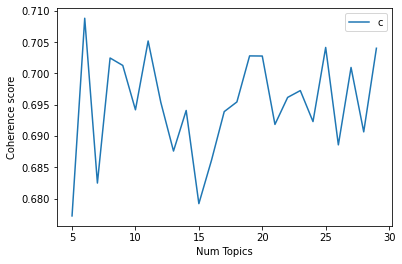

Num Topics = 5  has Coherence Value of 0.6773
Num Topics = 6  has Coherence Value of 0.7088
Num Topics = 7  has Coherence Value of 0.6825
Num Topics = 8  has Coherence Value of 0.7025
Num Topics = 9  has Coherence Value of 0.7013
Num Topics = 10  has Coherence Value of 0.6942
Num Topics = 11  has Coherence Value of 0.7052
Num Topics = 12  has Coherence Value of 0.6954
Num Topics = 13  has Coherence Value of 0.6876
Num Topics = 14  has Coherence Value of 0.6941
Num Topics = 15  has Coherence Value of 0.6792
Num Topics = 16  has Coherence Value of 0.6862
Num Topics = 17  has Coherence Value of 0.6939
Num Topics = 18  has Coherence Value of 0.6955
Num Topics = 19  has Coherence Value of 0.7028
Num Topics = 20  has Coherence Value of 0.7028
Num Topics = 21  has Coherence Value of 0.6919
Num Topics = 22  has Coherence Value of 0.6962
Num Topics = 23  has Coherence Value of 0.6973
Num Topics = 24  has Coherence Value of 0.6923
Num Topics = 25  has Coherence Value of 0.7042
Num Topics = 26  h

In [ ]:
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"  
!unzip -uq "/content/review_words.zip" -d "/content/"      

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
dirpath = '/content/review_words/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])
    
    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text] 

'''
def remove_stopwords(texts):
  for text in texts:
    return [word for word in simple_preprocess(str(text)) if word not in stop_words] 
'''

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word, 
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500) 
                                                 ##iterations=1500)   
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        model_list.append(model)   

        
         
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=30, step=1)



import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=5; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

In [ ]:
print(coherence_values[19])

0.576550174461658


review_words/Don’t let the weather forecast discourage you!_2, 2018_.txt:  mismatching "local" filename (review_words/DonтАЩt let the weather forecast discourage you!_2, 2018_.txt),
         continuing with "central" filename version
review_words/Don’t miss it_22, 2016_.txt:  mismatching "local" filename (review_words/DonтАЩt miss it_22, 2016_.txt),
         continuing with "central" filename version


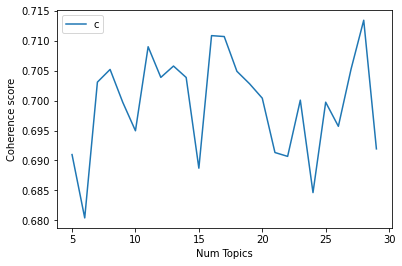

Num Topics = 5  has Coherence Value of 0.691
Num Topics = 6  has Coherence Value of 0.6804
Num Topics = 7  has Coherence Value of 0.7031
Num Topics = 8  has Coherence Value of 0.7052
Num Topics = 9  has Coherence Value of 0.6997
Num Topics = 10  has Coherence Value of 0.695
Num Topics = 11  has Coherence Value of 0.709
Num Topics = 12  has Coherence Value of 0.7039
Num Topics = 13  has Coherence Value of 0.7058
Num Topics = 14  has Coherence Value of 0.7039
Num Topics = 15  has Coherence Value of 0.6887
Num Topics = 16  has Coherence Value of 0.7109
Num Topics = 17  has Coherence Value of 0.7107
Num Topics = 18  has Coherence Value of 0.7049
Num Topics = 19  has Coherence Value of 0.7028
Num Topics = 20  has Coherence Value of 0.7004
Num Topics = 21  has Coherence Value of 0.6913
Num Topics = 22  has Coherence Value of 0.6907
Num Topics = 23  has Coherence Value of 0.7001
Num Topics = 24  has Coherence Value of 0.6846
Num Topics = 25  has Coherence Value of 0.6997
Num Topics = 26  has 

In [ ]:
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np

# Importing Gensim
import gensim
from gensim import corpora
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"  
!unzip -uq "/content/review_words.zip" -d "/content/"      

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
dirpath = '/content/review_words/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

import nltk

def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])
    
    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text] 

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]



from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word, 
                                                 ##workers=40,
                                                 ##optimize_interval=4,
                                                 iterations=5) 
                                                 ##iterations=1500)   
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        model_list.append(model)   

        
         
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=30, step=1)



import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=5; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)


In [ ]:
print(coherence_values[1])

0.708819542517784


In [ ]:
# install chromium, its driver, and selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

## print(driver.page_source)  # results

## driver.get("https://www.tripadvisor.com/Restaurant_Review-g190328-d8867662-Reviews-Storie_Sapori_La_Valletta-Valletta_Island_of_Malta.html")
## print(driver.page_source)  # results

import csv
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

##URL = "https://www.tripadvisor.com/Restaurant_Review-g190328-d8867662-Reviews-Storie_Sapori_La_Valletta-Valletta_Island_of_Malta.html"

##driver = webdriver.Chrome("./chromedriver")
##driver.get(URL)

# Prepare CSV file
csvFile = open("reviews_yellow_mountain_acient_street.csv", "w", newline='', encoding="utf-8")
## csvFile = open("reviews_yellow_mountain_Xihai.csv", "w", newline='', encoding="utf-8")
## csvFile = open("reviews_yellow_mountain_Xihai.csv", "w", newline='', encoding="utf-8")
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['Date','Title','Review'])
## csvWriter.writerow(['Contribution','Title','Review'])
## csvWriter.writerow(['Date','Contribution','Title','Review'])

## num_page = 99
num_page = 99

## driver.implicitly_wait(10)

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.chrome.options import Options
from time import sleep

## options = Options()
## options.add_argument("--disable-notifications")

## !pip install selenium==4.2.0 --force-reinstall
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--disable-notifications")
# open it, go to a website, and get results
driver = webdriver.Chrome('chromedriver',options=options)

## driver.manage().timeouts().implicitlyWait(40, TimeUnit.SECONDS);

from selenium import webdriver
from selenium.common.exceptions import TimeoutException


try:
    driver.set_page_load_timeout(1000)
    driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d550738-Reviews-Mt_Huangshan-Huangshan_Anhui.html")
    ## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d1826843-Reviews-Huangshan_UNESCO_Global_Geopark-Huangshan_Anhui.html")
    ## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d1969398-Reviews-Xihai_Great_Canyon-Huangshan_Anhui.html#REVIEWS")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d502831-Reviews-Tunxi_Ancient_Street-Huangshan_Anhui.html#REVIEWS")
    ## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d551319-Reviews-Celestial_Capital_Peak_Tian_Du_Feng-Huangshan_Anhui.html")
    ## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d2003195-Reviews-Shixin_Peak-Huangshan_Anhui.html")
    ## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d551309-Reviews-Greeting_Pine_Ying_Ke_Song-Huangshan_Anhui.html")
except TimeoutException as ex:
    isrunning = 0
    print("Exception has been thrown. " + str(ex))
    driver.close()


## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d550738-Reviews-Mt_Huangshan-Huangshan_Anhui.html")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d1826843-Reviews-Huangshan_UNESCO_Global_Geopark-Huangshan_Anhui.html")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d1969398-Reviews-Xihai_Great_Canyon-Huangshan_Anhui.html#REVIEWS")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d502831-Reviews-Tunxi_Ancient_Street-Huangshan_Anhui.html#REVIEWS")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d551319-Reviews-Celestial_Capital_Peak_Tian_Du_Feng-Huangshan_Anhui.html")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d2003195-Reviews-Shixin_Peak-Huangshan_Anhui.html")
## driver.get("https://www.tripadvisor.com/Attraction_Review-g303685-d551309-Reviews-Greeting_Pine_Ying_Ke_Song-Huangshan_Anhui.html")
## driver.get("https://www.tripadvisor.com/Hotel_Review-g60763-d1218720-Reviews-The_Standard_High_Line-New_York_City_New_York.html")

wait = WebDriverWait(driver, 20)
showmore_link_ = wait.until(EC.element_to_be_clickable((By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]")))


def save_body_to_file(destination_path, filename, body):

    with open(destination_path  + filename, 'w') as file:
        file.write(body)
    file.close()

## driver.find_element(By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]").click()

## anchor = WebDriverWait(driver,100).until(EC.element_to_be_clickable( (By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]")))

## anchor.click()

##driver.manage().window().maximize();

###anchor = driver.find_element(By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]")
# change the value inside the range to save more or less reviews
for i in range(0, num_page):

    # expand the review 
    time.sleep(2)
    ## driver.find_elements(By.XPATH, ".//div[contains(@data-test-target, 'expand-review')]")
    ## driver.find_elements(By.XPATH, ".//span[@class='biGQs _P XWJSj Wb']")

    driver.find_elements(By.XPATH, "//span[@class='lszDU']")

    container = driver.find_elements(By.XPATH, "//div[@data-automation='reviewCard']")
    ## dates = driver.find_elements(By.XPATH, ".//div[@class='EftBQ']")
    ## dates = driver.find_elements(By.XPATH, ".//span[@class='teHYY _R Me S4 H3']")
    dates = driver.find_elements(By.XPATH, ".//div[@class='biGQs _P pZUbB ncFvv osNWb']")

    for j in range(len(container)):

        ##rating = container[j].find_element(By.XPATH, ".//span[contains(@class, 'ui_bubble_rating bubble_')]").get_attribute("class").split("_")[3]
        ## contribution = container[j].find_elements(By.XPATH, ".//span[@class='IugUm']")
        title = container[j].find_element(By.XPATH, ".//div[@class='biGQs _P fiohW qWPrE ncFvv fOtGX']//span[@class='yCeTE']").text
        review = container[j].find_element(By.XPATH, ".//div[1]/div/span[@class='yCeTE']").text.replace("\n", "")
        date = " ".join(dates[j].text.split(" ")[-2:])

         ##a1 = 'samp"le s"tring'
        title = title.replace('"','')

        exclude = '//'
        title = ''.join(ch for ch in title if ch not in exclude)
        ## title.replace(r'/', ' ')

        csvWriter.writerow([date, title, review]) 



        ##if title == "":
          ##title = "empty"
        ##else :
        filename = title + '_' + date + '_'  + ".txt"

        save_body_to_file(dirpath_, filename, review)
        
    ## driver.manage().window().maximize();
    # change the page    
    ## driver.find_element_by_xpath('.//a[@class="ui_button nav next primary "]').click()       
    ## driver.find_element(By.XPATH, '//*a[@href="/Attraction_Review-g303685-d550738-Reviews-or10-Mt_Huangshan-Huangshan_Anhui.html"]').click() 
    ## driver.find_element(By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]").click()
    
 
'''   wait = WebDriverWait(driver, 100)

    try:
        showmore_link = wait.until(EC.element_to_be_clickable((By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]")))
        showmore_link.click()

    except ElementClickInterceptedException:
        print("Trying to click on the button again")
        driver.execute_script("arguments[0].click()", showmore_link)
 '''       
    ## anchor_ = driver.find_element(By.XPATH, "//*[contains(@data-smoke-attr, 'pagination-next-arrow')]")

    ##JavaScriptExecutor.ExecuteScript("window.scrollTo(0, 0);");
    ## driver.execute_script("window.scrollTo(0, 0);")
    ## driver.manage().window().maximize();
    ## anchor_.click() 
    ##response.xpath('//a[@class="prevNext" and contains(text(),"Next")]/@href')
    ##restrict_xpaths='(//a[@class="prevNext" and contains(text(),"Next")])[1]'




driver.quit()



In [ ]:
!zip -r reviews_words.zip reviews_words/

In [ ]:
# Select the model and print the topics
optimal_model = model_list[14]


# Finding the dominant topic in each document 

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(20)

Document_No  Dominant_Topic  Topic_Contrib  \
0             0            10.0         0.3432   
1             1             2.0         0.3267   
2             2             6.0         0.3295   
3             3            17.0         0.3721   
4             4             2.0         0.3614   
5             5             1.0         0.2847   
6             6            18.0         0.2859   
7             7            10.0         0.5624   
8             8             4.0         0.2675   
9             9            13.0         0.4571   
10           10             6.0         0.5200   
11           11            10.0         0.6239   
12           12             6.0         0.4204   
13           13             1.0         0.2404   
14           14            17.0         0.3085   
15           15            15.0         0.2793   
16           16            13.0         0.8119   
17           17             2.0         0.5911   
18           18            13.0         0.2985   
19           19            12.0         0.3803   

                                             Keywords  \
0   tiandu, idea, disliked, uninterrupted, shorten...   
1   backtracking, awestruck, mistake, kill, stunne...   
2   campsite, pitch, shortened, wont, camellia, is...   
3   regardless, safety, froze, lengthy, recycling,...   
4   backtracking, awestruck, mistake, kill, stunne...   
5   red, bunk, trek, waaaaaa, throwing, stamen, pl...   
6   confines, extravagant, zhaixi, solitude, cheap...   
7   tiandu, idea, disliked, uninterrupted, shorten...   
8   orderly, provision, frontage, biscuit, fading,...   
9   flea, yet, leisurelythan, overweight, furong, ...   
10  campsite, pitch, shortened, wont, camellia, is...   
11  tiandu, idea, disliked, uninterrupted, shorten...   
12  campsite, pitch, shortened, wont, camellia, is...   
13  red, bunk, trek, waaaaaa, throwing, stamen, pl...   
14  regardless, safety, froze, lengthy, recycling,...   
15  therapy, pouring, crook, used, versus, unavoid...   
16  flea, yet, leisurelythan, overweight, furong, ...   
17  backtracking, awestruck, mistake, kill, stunne...   
18  flea, yet, leisurelythan, overweight, furong, ...   
19  lump, pilgrimage, indoors, midday, product, ra...   

                                                 Text  \
0   [want, pay, cable, opt, hike, mountain, rememb...   
1   [jane, jane, jane, couching, tiger, hidden, dr...   
2   [easy, place, visit, without, knowing, chinese...   
3   [family, spent, day, huangshan, area, wonderfu...   
4   [booked, private, tour, china, highlight, webs...   
5   [like, crowd, go, week, day, avoid, golden, we...   
6   [cool, one, thousand, beautiful, tree, mountai...   
7   [t, trip, huangshan, travelled, beijing, huang...   
8   [never, seen, elsewhere, misty, clear, still, ...   
9   [old, stree, hotel, fun, place, spend, couple,...   
10  [never, seen, anything, like, place, easy, get...   
11  [main, objective, many, chinese, visitor, come...   
12  [sea, cloud, imo, huangshan, beautiful, mounta...   
13  [mountain, climbing, engaged, regular, exercis...   
14  [one, popular, mountain, china, brings, millio...   
15  [mt, huangshan, beautiful, national, park, sun...   
16  [tunxi, ancient, shopping, street, well, prese...   
17  [experience, yellow, mountain, truly, spectacu...   
18  [toured, many, old, town, china, almost, count...   
19  [loved, xihai, grand, canyon, time, complete, ...   

                                                 Name  
0                                2 Days in a painting  
1   2 night trip to Mt. Huangshan great thanks to ...  
2                           24 hours at Mt. Huangshan  
3                                 3 days in Huangshan  
4                     3-day Essence of Huangshan tour  
5                                  8 miles of Wonder!  
6   A 'must-see' for Chinese....foreigners maybe.....  
7                            A 5star in sunny weather  
8   A 6 star experience - Pack strong legs and bra...

In [ ]:
df_dominant_topic.head(20)

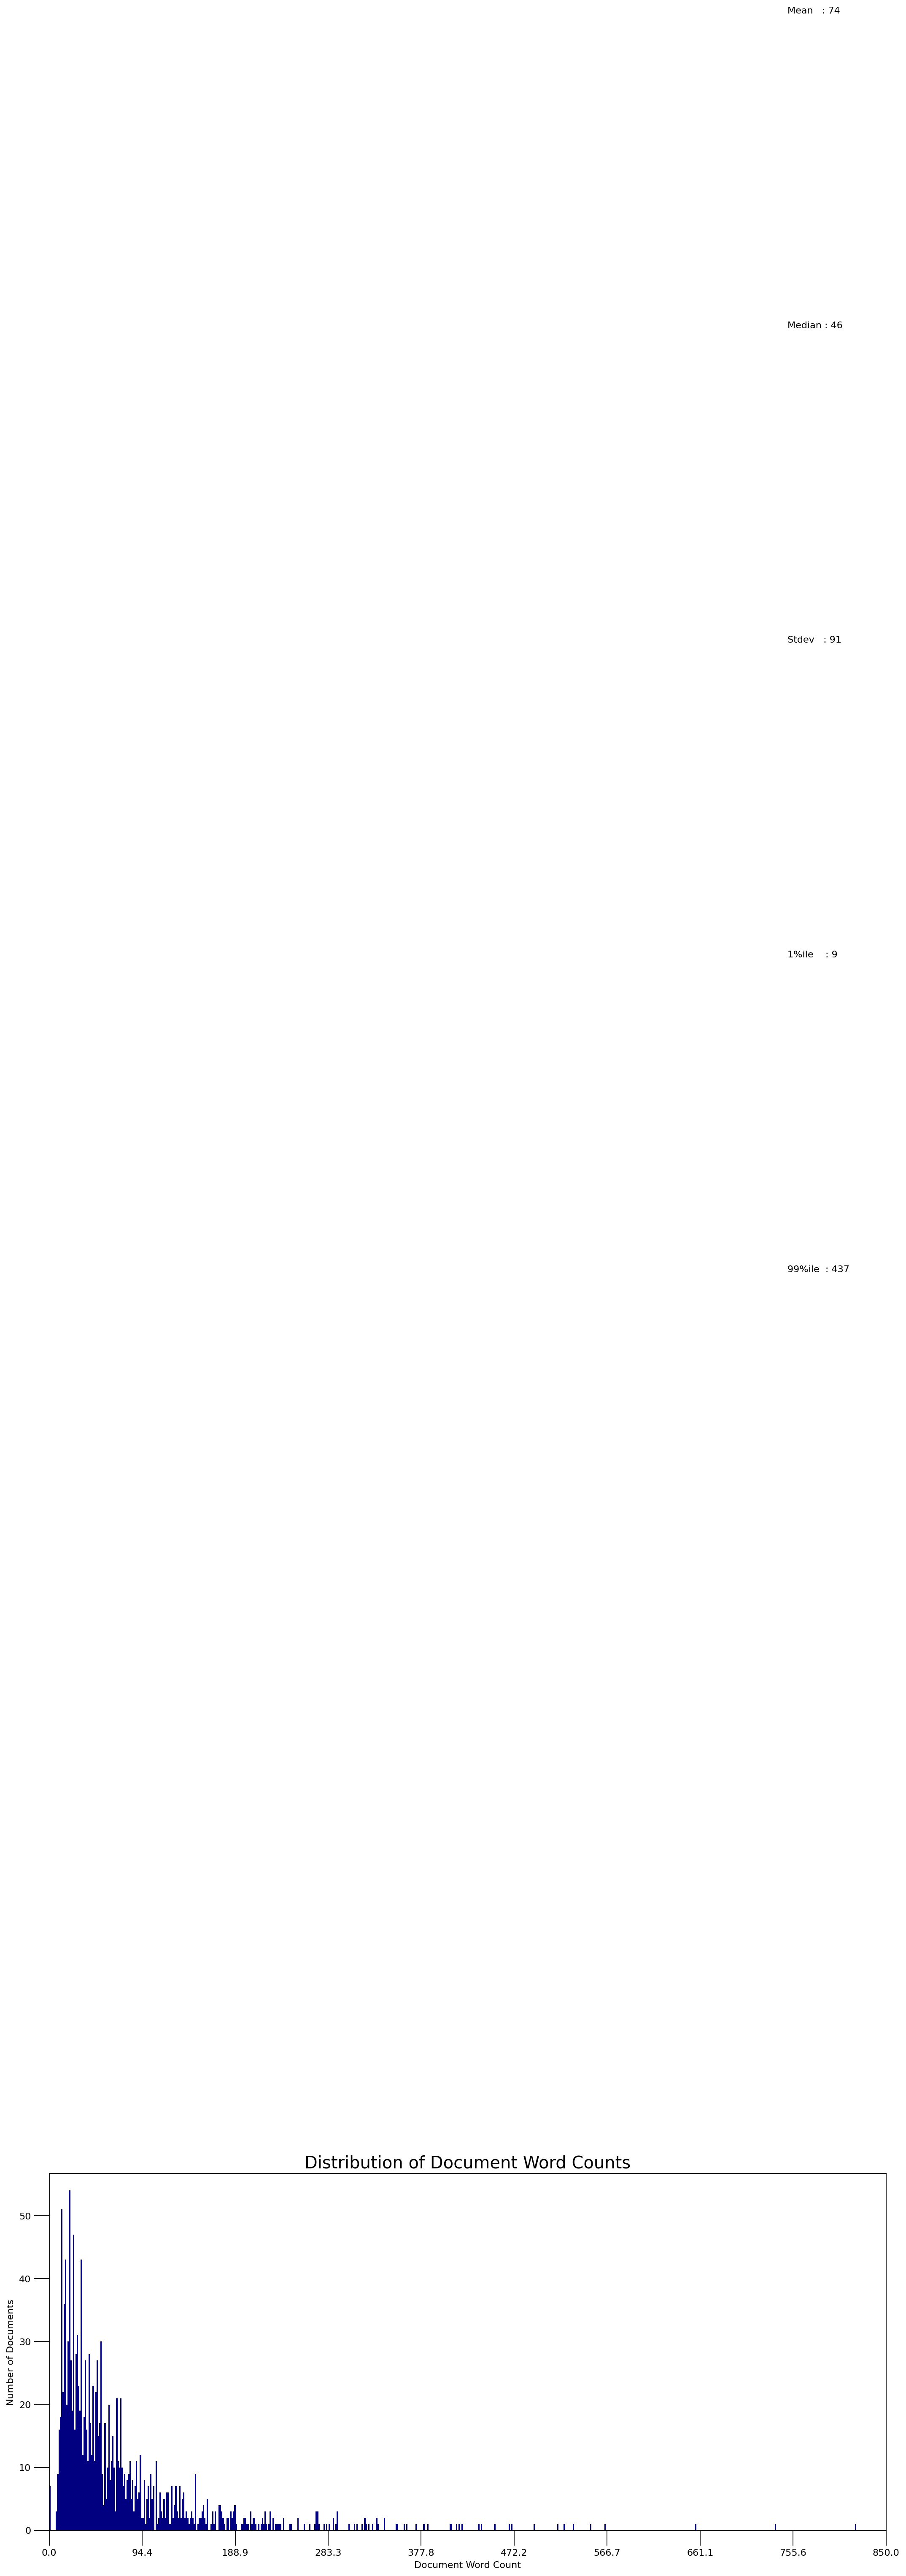

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 400, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 350, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 250, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 200, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 850), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,850,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()


In [ ]:
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np

# Importing Gensim
import gensim
from gensim import corpora
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"  
!unzip -uq "/content/reviews_words.zip" -d "/content/"      

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
dirpath = '/content/reviews_words/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

import nltk

def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])
    
    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text] 

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]



# Build LDA model
## lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=20)
## lda_multicore_model = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics = NUM_TOPICS, id2word=dictionary,random_state=100,passes=10)

## lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=1/20,
                                           eta=1/20,
                                           per_word_topics=True)
                                           



from pprint import pprint
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Converting list of documents (corpus) into Document Term Matrix using the dictionary 
## doc_term_matrix = [id2word.doc2bow(i) for i in data_lemmatized]


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        Lda = gensim.models.ldamodel.LdaModel
        model = Lda(corpus=corpus, num_topics=num_topics, id2word = id2word, passes=20, random_state=30, eval_every=None)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=5)


limit=20; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


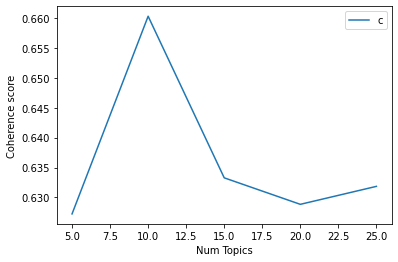

Num Topics = 5  has Coherence Value of 0.6272
Num Topics = 10  has Coherence Value of 0.6603
Num Topics = 15  has Coherence Value of 0.6333
Num Topics = 20  has Coherence Value of 0.6288
Num Topics = 25  has Coherence Value of 0.6319


In [ ]:

import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=5; step=5;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)


In [ ]:
# for text preprocessing
import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np

# Importing Gensim
import gensim
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
from pprint import pprint

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


#dirpath = '/content/drive/MyDrive/lda_silhouette/Names_no_duplicates/'
## dirpath = '/content/drive/MyDrive/Names_2000/'
#output = '/content/drive/MyDrive/lda_silhouette/name.csv'
!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names" -d "/content/"
## !unzip -uq "/content/mallet-2.0.8" -d "/content/"  

dirpath = '/content/Names_207039/'
output = '/content/name.csv'
import os

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus += [f.read()]
# corpus


# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):
   
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
   
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)  
   
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus]
data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]



imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



"""
# Build LDA model
## lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,                                            
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           ## alpha='auto',
                                           alpha='symmetric',
                                           eta=0.0001,
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
print(lda_model.print_topics())

# spacy for lemmatization
import spacy

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


"""


# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        Lda = gensim.models.ldamodel.LdaModel
# Running and Training LDA model on the document term matrix.
## ldamallet = Lda(doc_term_matrix, num_topics=10, id2word = id2word, passes=20, alpha=0.01, eta=0.0001, random_state=30, eval_every=None)
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        ## model = Lda(doc_term_matrix, num_topics=10, id2word = id2word, passes=20, alpha=0.01, eta=0.0001, random_state=30, eval_every=None)
        model = gensim.models.ldamulticore.LdaMulticore(doc_term_matrix, 
                                                        num_topics=num_topics, 
                                                        id2word = id2word, 
                                                        passes=5, 
                                                        random_state=30, 
                                                        eval_every=None)
        ## model = Lda(doc_term_matrix, num_topics=num_topics, id2word = id2word, passes=20, alpha=0.01, eta=0.0001, random_state=30, eval_every=None)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# for text preprocessing
import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np

# Importing Gensim
import gensim
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
from pprint import pprint

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


#dirpath = '/content/drive/MyDrive/lda_silhouette/Names_no_duplicates/'
## dirpath = '/content/drive/MyDrive/Names_2000/'
#output = '/content/drive/MyDrive/lda_silhouette/name.csv'
!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names" -d "/content/"
## !unzip -uq "/content/mallet-2.0.8" -d "/content/"  

dirpath = '/content/Names_207039/'
output = '/content/name.csv'
import os

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus += [f.read()]
# corpus


# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):
   
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
   
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)  
   
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus]
data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]



imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



"""
# Build LDA model
## lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,                                            
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           ## alpha='auto',
                                           alpha='symmetric',
                                           eta=0.0001,
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
print(lda_model.print_topics())

# spacy for lemmatization
import spacy

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


"""


# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        Lda = gensim.models.ldamodel.LdaModel
# Running and Training LDA model on the document term matrix.
## ldamallet = Lda(doc_term_matrix, num_topics=10, id2word = id2word, passes=20, alpha=0.01, eta=0.0001, random_state=30, eval_every=None)
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        ## model = Lda(doc_term_matrix, num_topics=10, id2word = id2word, passes=20, alpha=0.01, eta=0.0001, random_state=30, eval_every=None)
        model = gensim.models.ldamulticore.LdaMulticore(doc_term_matrix, 
                                                        num_topics=num_topics, 
                                                        id2word = id2word, 
                                                        passes=5, 
                                                        random_state=30, 
                                                        eval_every=None)
        ## model = Lda(doc_term_matrix, num_topics=num_topics, id2word = id2word, passes=20, alpha=0.01, eta=0.0001, random_state=30, eval_every=None)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
print(texts[:1])

[['This', 'worth', 'making', 'a', 'trip', 'to', 'you', 'are', 'China', 'you', 'can', 'get', 'most', 'of', 'the', 'top', 'of', 'the', 'mountain', 'done', 'one', 'day', 'Please', 'note', 'that', 'the', 'cable', 'cars', 'have', 'rotating', 'outages', 'maintenance', 'November', 'to', 'January', 'every', 'year', 'it', 'quite', 'a', 'bit', 'of', 'a', 'hike', 'up', 'down', 'We', 'went', 'late', 'December', 'went', 'up', 'the', 'Yungu', 'cable', 'car', 'hiked', 'to', 'Yuping', 'The', 'trail', 'about', 'km', 'of', 'walking', 'took', 'us', 'about', 'hours', 'then', 'another', 'hours', 'to', 'hike', 'down', 'near', 'Yuping', 'The', 'cable', 'cars', 'take', 'about', 'minutes', 'to', 'go', 'up', 'down', 'cost', 'RMB', 'one', 'way', 'The', 'ticket', 'price', 'was', 'RMB', 'to', 'enter', 'the', 'park', 'We', 'would', 'recommend', 'staying', 'Tankou', 'Town', 'a', 'trip', 'to', 'the', 'mountain', 'buying', 'your', 'own', 'snacks', 'town', 'regular', 'items', 'are', 'two', 'to', 'three', 'times', 'the'

In [ ]:
# copy

from pprint import pprint
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word, 
                                                 ##workers=40,
                                                 ##optimize_interval=4,
                                                 iterations=50) 
                                                 ##iterations=1500)   
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)   
         
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=55, step=5)



import csv  

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=55; start=5; step=5;

    x = range(start, limit, step)

    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)


In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib
import time
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)

from utils import load_data
from utils import preprocess_pipeline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Saving utils.py to utils (5).py


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

results = []

for num_topics in range(2, 8, 1):
    ## lda_model = model.LsiModel(corpus, id2word=dictionary, num_topics=t)
    ## corpus_lsi = lda_model[corpus]

    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(doc_term_matrix, num_topics=num_topics, id2word = id2word, passes=20, random_state=30, eval_every=None)

    corpus_lda = model[corpus]


    X = np.array([[float(tup[1]) for tup in arr] for arr in corpus_lda])
    kmeans = KMeans(n_clusters=num_topics, random_state=37).fit(X)

    score = silhouette_score(X, kmeans.labels_)

    tup = num_topics, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [ ]:
w = lda_model.get_topics()
w

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]


# Finding the dominant topic in each document 

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(207039)

Document_No  Dominant_Topic  Topic_Contrib  \
0               0             6.0         0.3309   
1               1             6.0         0.5781   
2               2             1.0         0.7884   
3               3            11.0         0.6043   
4               4            11.0         0.9665   
...           ...             ...            ...   
1994         1994             4.0         0.5536   
1995         1995             6.0         0.5528   
1996         1996             6.0         0.6826   
1997         1997             6.0         0.8403   
1998         1998             9.0         0.5002   

                                               Keywords  \
0     tensor, input, shape, torch, output, layer, gr...   
1     tensor, input, shape, torch, output, layer, gr...   
2     event, respons, output, type, content, histori...   
3     loss, task, train, sampl, job, param, target, ...   
4     loss, task, train, sampl, job, param, target, ...   
...                                                 ...   
1994  floor, float, copi, equal, predict, pytest, ed...   
1995  tensor, input, shape, torch, output, layer, gr...   
1996  tensor, input, shape, torch, output, layer, gr...   
1997  tensor, input, shape, torch, output, layer, gr...   
1998  mock, call, messag, client, json, command, get...   

                                                   Text  \
0     [rmse, correct, pred, torch, tensor, repeat, t...   
1     [diagon, add, scalar, torch, randn, plu, diag,...   
2     [creat, token, first, first, tri, creat, datas...   
3     [dont, restart, download, job, still, run, job...   
4     [first, set, mock, network, call, experi, comp...   
...                                                 ...   
1994  [matrix, matrix, array, noisi, random, rand, m...   
1995  [max, cluster, max, cluster, array, result, ma...   
1996  [trace, doe, contain, hard, code, constant, si...   
1997  [output, box, convert, tensor, dtype, torch, f...   
1998  [spark, resourc, avail, fallback, arg, gpu, sp...   

                                                   Name  
0     AIStream-Peelout_flow-fore__test_loss.py_4_tes...  
1     AlexImmer_Lap__test_utils.py_2_test_diagonal_a...  
2     AlexsLemonade_refin__test_dataset.py_5_test_cr...  
3     AlexsLemonade_refin__test_downloader_job_manag...  
4     AlexsLemonade_refin__test_organism_shepherd.py...  
...                                                 ...  
1994  wq2012_SpectralClu__configs_test.py_1_test_100...  
1995  wq2012_SpectralClu__utils_test.py_5_test_max_c...  
1996  xingyizhou_Center__test_imagelist.py_1_test_im...  
1997  xingyizhou_Un__test_boxes.py_10_test_box_conve...  
1998  yahoo_TensorFlowOnS__test_TFSparkNode.py_8_tes...  

[1999 rows x 6 columns]

In [ ]:

# Finding the dominant topic in each document 

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, topn=20)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(207039)

NameError: ignored

In [ ]:
lda_model.print_topics(num_words=15)

In [ ]:
[ [(id2word[wid], s) for (wid, s) in lda_model.get_topic_terms(tid, topn=15)] for tid in range(20)]

In [ ]:
x=lda_model.show_topics(num_topics=26, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ ", "+ str(words))
print()

#Below Code Prints Only Words 
## for topic,words in topics_words:
    ## print(" ".join(words))

In [ ]:
# Finding the most representative document (top20) for each topic

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(15)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Name"]

# Display
sent_topics_sorteddf.head(300)